# Aplicación de Machine Learning para la Detección de Anomalías

Alumno/a: Aizane Rubio Iturria\
Titulación: Máster Oficial en Big Data y Data Science\
Curso Académico: 2023-2024 \
Director/a del TFM: Cristina Caro González

## INTRODUCCIÓN

Este Trabajo Fin de Máster se centra en el uso de técnicas de Machine Learning para detectar anomalías, principalmente relacionadas con ciberseguridad. Su principal objetivo es evaluar el estado de la ciberseguridad de una empresa líder en soluciones tecnológicas utilizando diferentes bases de datos de ciberseguridad, como A Realistic Cyber Defense Dataset (CSE-CIC-IDS2018). 

## OBJETIVO

El objetivo principal de este Trabajo de Fin de Máster es evaluar y analizar el estado de la ciberseguridad de una empresa, basándose en el análisis de su tráfico de red y registros del sistema. Además, se diseñará un modelo capaz de detectar y clasificar los tipos de ataques recibidos, lo que facilitará la toma de decisiones sobre las medidas de protección a implementar. Para ello, será necesario aplicar técnicas avanzadas de Ciencia de Datos.

En particular, se busca desarrollar un modelo de Detección de Anomalías que identifique los patrones detrás de los ataques de fuerza bruta en protocolos como FTP y SSH, unos de los más comunes en el ámbito empresarial. El objetivo es poder diferenciarlos del tráfico benigno, no solo para conocer el nivel de exposición de la empresa a este tipo de amenazas, sino también como una medida preventiva que permita detectar futuros ataques a tiempo.

## METODOLOGÍA

El análisis se ha ejecutado mediante varias fases. La primera fase, se centra en la limpieza de datos. Este proceso incluye la eliminación de columnas irrelevantes, el tratamiento de valores nulos y de valores erróneos, como valores infinitos o negativos, que no tienen sentido en el contexto del análisis. En la segunda fase, se lleva a cabo la transformación de los datos, donde las variables categóricas se convierten en numéricas y se estandarizan los valores, un paso importante para asegurar la correcta aplicación de los modelos de Machine Learning. El método de escalado de datos es el escalado robusto (Ro- bustScaler ). Una vez finalizadas estas etapas, se emplea LigthGBM, un método de selección de características, para identificar y retener únicamente las variables más significativas.

Con el preprocesamiento completo, el conjunto de datos se divide en tres subconjuntos: entrenamiento, validación y prueba. Los subconjuntos de entrenamiento y validación se utilizan para entrenar los modelos y seleccionar los algoritmos y parámetros que mejor se ajusten a los datos. El conjunto de prueba se reserva única- mente para la evaluación final, proporcionando una métrica que refleja la capacidad del modelo para generalizar ante datos que no ha visto previamente. El proceso de entrenamiento se ejecuta sobre diferentes  del conjunto de entrenamiento inicial, cada una tratada con una técnica distinta de manejo del desbalanceo de clases. En el primer conjunto, los datos se mantienen sin mo- dificaciones. En el segundo, se aplica downsampling (reducción del tamaño de las clases mayoritarias), mientras que en el tercero se emplea upsampling (aumento de las clases minoritarias). Por último, en el cuarto conjunto se combinan ambas técnicas aplicando \textit{downsampling} de la clase mayoritaria y \textit{upsampling} de la minoritaria.

Después de aplicar estos métodos, se evalúan seis algoritmos de aprendizaje automático para abordar el problema de clasificación multiclase, examinando su rendimiento y adaptabilidad a los datos preprocesados y balanceados. Los mejores modelos se seleccionan y ajustan mediante la optimización de sus hiperparámetros. Finalmente, se evalúa el rendimiento de cada modelo para determinar su capacidad de generalización.


## ANÁLISIS DE DATOS

In [10]:
# INSTALACIÓN

#!pip install lightgbm 
#!pip install autofeatselect
#!pip install imbalanced-learn

In [18]:
# LIBRERIAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import joblib

# Transformación
from sklearn.preprocessing import RobustScaler
from autofeatselect import CorrelationCalculator, FeatureSelector, AutoFeatureSelect
from imblearn.over_sampling import SMOTE

# Machine Learnign
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score


In [19]:
# RUTAS LOCAL
csv_IDS2018 = r"C:\Users\AIZANE\~\datasets\Processed Traffic Data for ML Algorithms/"
ruta_intermedia = r"C:\Users\AIZANE\Documents\MASTER\TFM/"

In [ ]:
# RUTAS DRIVE

#RUTAS DRIVE
from google.colab import drive
drive.mount('/content/drive')

# Esta ruta se utiliza para leer la base de datos 
csv_IDS2018 = r"/content/drive/My Drive/TFM_AIZANE_RUBIO/NOTEBOOKS/Proceso_KDD/"
# Esta ruta se utiliza para el resto de lecturas
ruta_intermedia = r"/content/drive/My Drive/TFM_AIZANE_RUBIO/NOTEBOOKS/Proceso_KDD/modelos/"

In [20]:
# VARIABLES GENERALES

# Semilla para que el código sea reproducible
seed = 42
#Paleta de colores
colores_pastel = ['#FA8072',
                  '#87CEEB', 
                  '#FFA07A', 
                  '#98FB98', 
                  '#FFD700', 
                  '#FFB6C1'] 

# 1. TIPO DE ATAQUE BRUTE-FORCE

In [53]:
# Leer el archivo CSV y reemplazar LOS espacios por guiones bajos en los nombres de las columnas
IDS2018_BruteForce = pd.read_csv(csv_IDS2018 + 'Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv')
IDS2018_BruteForce.columns = IDS2018_BruteForce.columns.str.replace(' ', '_')

In [8]:
# DESPUÉS DE LA LIMPIEZA
counts = IDS2018_BruteForce['Label'].value_counts()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Recuento de cada tipo en la columna 'Label':")
print(counts)

Recuento de cada tipo en la columna 'Label':
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64


In [9]:
# Analizamos lo balanceada que está la clase
tipo_ataque = IDS2018_BruteForce['Label'].unique()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Tipos de ataques registrados:")
print(tipo_ataque)

Tipos de ataques registrados:
['Benign' 'FTP-BruteForce' 'SSH-Bruteforce']


## 1. KDD - Fases iniciales: Exploración, limpieza y  transformación de datos

### 1.1 Exploración general

Realizamos un primer análisis general, para conocer la estructura del dataset.

In [10]:
# Comprobamos tamaño del dataset
IDS2018_BruteForce.shape

(1048575, 80)

In [11]:
# Columnas
IDS2018_BruteForce.columns

Index(['Dst_Port', 'Protocol', 'Timestamp', 'Flow_Duration', 'Tot_Fwd_Pkts',
       'Tot_Bwd_Pkts', 'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max',
       'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std',
       'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean',
       'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean',
       'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Tot',
       'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min',
       'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max',
       'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Fwd_URG_Flags',
       'Bwd_URG_Flags', 'Fwd_Header_Len', 'Bwd_Header_Len', 'Fwd_Pkts/s',
       'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean',
       'Pkt_Len_Std', 'Pkt_Len_Var', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt',
       'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt',
       'CWE_Flag_Count', 'ECE_Flag_Cnt', 'Down/Up_Ratio', 'Pkt_Size_Avg',
      

In [49]:
print(IDS2018_BruteForce.head())

   Dst_Port  Protocol            Timestamp  Flow_Duration  Tot_Fwd_Pkts  \
0         0         0  14/02/2018 08:31:01      112641719             3   
1         0         0  14/02/2018 08:33:50      112641466             3   
2         0         0  14/02/2018 08:36:39      112638623             3   
3        22         6  14/02/2018 08:40:13        6453966            15   
4        22         6  14/02/2018 08:40:23        8804066            14   

   Tot_Bwd_Pkts  TotLen_Fwd_Pkts  TotLen_Bwd_Pkts  Fwd_Pkt_Len_Max  \
0             0                0                0                0   
1             0                0                0                0   
2             0                0                0                0   
3            10             1239             2273              744   
4            11             1143             2209              744   

   Fwd_Pkt_Len_Min  ...  Fwd_Seg_Size_Min  Active_Mean  Active_Std  \
0                0  ...                 0          0.0    

In [51]:
IDS2018_BruteForce.describe()

,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,...,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,...,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,4.876262e+03,8.107557e+00,6.255555e+06,6.206622e+00,7.211191e+00,4.479936e+02,4.521803e+03,1.745736e+02,8.389535e+00,3.879579e+01,...,2.793536e+00,2.327970e+01,5.152449e+04,2.136151e+04,8.789157e+04,3.995477e+04,3.101206e+06,7.297218e+05,4.812391e+06,2.126920e+06
std,1.444344e+04,4.460625e+00,1.260291e+09,4.447851e+01,1.048682e+02,1.573541e+04,1.515021e+05,2.876713e+02,1.948279e+01,5.331882e+01,...,5.557106e+00,1.106185e+01,5.815586e+05,2.186405e+05,7.395725e+05,5.602693e+05,5.414780e+08,3.820031e+08,1.522117e+09,1.817013e+07
min,0.000000e+00,0.000000e+00,-9.190110e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.200000e+01,6.000000e+00,7.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.300000e+01,6.000000e+00,1.023000e+03,2.000000e+00,1.000000e+00,3.600000e+01,5.500000e+01,3.400000e+01,0.000000e+00,2.566667e+01,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,6.000000e+00,4.066690e+05,7.000000e+00,6.000000e+00,4.550000e+02,7.680000e+02,1.990000e+02,0.000000e+00,5.550000e+01,...,4.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553300e+04,1.700000e+01,1.200000e+08,5.115000e+03,9.198000e+03,8.591554e+06,1.339773e+07,6.444000e+04,1.460000e+03,1.121703e+04,...,1.031000e+03,4.800000e+01,1.102401e+08,5.723446e+07,1.102401e+08,1.102401e+08,3.394503e+11,2.432682e+11,9.797810e+11,1.260300e+10


In [53]:
IDS2018_BruteForce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst_Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow_Duration      1048575 non-null  int64  
 4   Tot_Fwd_Pkts       1048575 non-null  int64  
 5   Tot_Bwd_Pkts       1048575 non-null  int64  
 6   TotLen_Fwd_Pkts    1048575 non-null  int64  
 7   TotLen_Bwd_Pkts    1048575 non-null  int64  
 8   Fwd_Pkt_Len_Max    1048575 non-null  int64  
 9   Fwd_Pkt_Len_Min    1048575 non-null  int64  
 10  Fwd_Pkt_Len_Mean   1048575 non-null  float64
 11  Fwd_Pkt_Len_Std    1048575 non-null  float64
 12  Bwd_Pkt_Len_Max    1048575 non-null  int64  
 13  Bwd_Pkt_Len_Min    1048575 non-null  int64  
 14  Bwd_Pkt_Len_Mean   1048575 non-null  float64
 15  Bwd_Pkt_Len_Std    1048575 non-n

### 1.2 Limpieza de datos

#### 1.2.1 Eliminar Columnas innecesarias

En este análisis, la variable de tiempo no es relevante. Aunque es posible que ciertos ataques ocurran en horas similares del día, nuestro enfoque se centra en detectar los ataques en función de sus características intrínsecas, independientemente del momento en que se produzcan. Es decir, al eliminar la variable de tiempo damos a entender que no nos interesa predecir cuando va a ocurrir un ataque sino que queremos detectar y clasificar los ataques.

In [54]:
IDS2018_BruteForce_v0 = IDS2018_BruteForce.drop('Timestamp', axis=1)

La base de datos contiene columnas que toman el mismo valor para cada registro, esto hace que no sean interesantes a la hora de crear nuestro modelo.

In [56]:
len(IDS2018_BruteForce_v0.columns)

79

Eliminamos las variables que no aportan variabilidad.

In [57]:
for column in IDS2018_BruteForce_v0.columns:
    unique_vals = IDS2018_BruteForce_v0[column].unique()
    if len(unique_vals)==1:
        IDS2018_BruteForce_v0 = IDS2018_BruteForce_v0.drop(column, axis=1)
        print(f'La columna "{column}" tiene el mismo valor en todos los registros:{unique_vals} y ha sido eliminada de la base de datos')

La columna "Bwd_PSH_Flags" tiene el mismo valor en todos los registros:[0] y ha sido eliminada de la base de datos
La columna "Fwd_URG_Flags" tiene el mismo valor en todos los registros:[0] y ha sido eliminada de la base de datos
La columna "Bwd_URG_Flags" tiene el mismo valor en todos los registros:[0] y ha sido eliminada de la base de datos
La columna "CWE_Flag_Count" tiene el mismo valor en todos los registros:[0] y ha sido eliminada de la base de datos
La columna "Fwd_Byts/b_Avg" tiene el mismo valor en todos los registros:[0] y ha sido eliminada de la base de datos
La columna "Fwd_Pkts/b_Avg" tiene el mismo valor en todos los registros:[0] y ha sido eliminada de la base de datos
La columna "Fwd_Blk_Rate_Avg" tiene el mismo valor en todos los registros:[0] y ha sido eliminada de la base de datos
La columna "Bwd_Byts/b_Avg" tiene el mismo valor en todos los registros:[0] y ha sido eliminada de la base de datos
La columna "Bwd_Pkts/b_Avg" tiene el mismo valor en todos los registros:[

In [58]:
len(IDS2018_BruteForce_v0.columns)

69

#### 1.2.2 Eliminar filas con registros invalidos: nulos, infinitos y valores negativos

Detectamos valores nulos.

In [61]:
# Analizamos si nuestra base de datos tiene valores nulos
for column in IDS2018_BruteForce_v0.columns:
    num_null = IDS2018_BruteForce_v0[column].isna().sum()
    if num_null>0:
        print(f'Column "{column}" has {num_null} null values')

Column "Flow_Byts/s" has 2277 null values


Vemos que una única columna tiene valores nulos, que representan un 0,2% del total de rgistros de la misma. Al ser un porcentaje tan bajo se ha decidido eliminar estos registros.

In [63]:
IDS2018_BruteForce_v0.dropna(axis=1, inplace=True)

Valores invalidos como negativos o infinitos.\
Los valores infinitos y negativos no son válidos porque no representan situaciones realistas en el contexto de tráfico de red, y su presencia puede afectar negativamente la precisión y efectividad de los modelos de detección de intrusiones. Por tanto, es necesario eliminarlos o tratarlos.

In [65]:
IDS2018_BruteForce_v0.shape

(1048575, 68)

In [66]:
# Reemplazar los valores infinitos (np.inf, -np.inf) con NaN
IDS2018_BruteForce_v0.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar las filas que tienen valores NaN (que eran originalmente infinitos)
IDS2018_BruteForce_v0.dropna(inplace=True)

In [67]:
IDS2018_BruteForce_v0.shape
# Se han eliminado 3.824 registros

(1044751, 68)

In [68]:
# Seleccionar solo las columnas numéricas
numeric_columns = IDS2018_BruteForce_v0.select_dtypes(include=[int, float]).columns

# Recorrer cada columna numérica del DataFrame
for column in numeric_columns:
    # Contar la cantidad de valores negativos en la columna actual
    num_neg = (IDS2018_BruteForce_v0[column] < 0).sum()
    
    # Filtrar las filas que tienen valores negativos en la columna actual
    bbdd = IDS2018_BruteForce_v0[IDS2018_BruteForce_v0[column] < 0]
    
    # Si la columna tiene valores negativos, imprimir el resultado
    if num_neg > 0:
        print(f'La columna "{column}" tiene {num_neg} valores negativos')

La columna "Flow_Duration" tiene 5 valores negativos
La columna "Flow_Pkts/s" tiene 5 valores negativos
La columna "Flow_IAT_Mean" tiene 5 valores negativos
La columna "Flow_IAT_Max" tiene 2 valores negativos
La columna "Flow_IAT_Min" tiene 5 valores negativos
La columna "Fwd_IAT_Tot" tiene 5 valores negativos
La columna "Fwd_IAT_Mean" tiene 5 valores negativos
La columna "Fwd_IAT_Max" tiene 2 valores negativos
La columna "Fwd_IAT_Min" tiene 5 valores negativos
La columna "Init_Fwd_Win_Byts" tiene 219266 valores negativos
La columna "Init_Bwd_Win_Byts" tiene 343608 valores negativos


**Flow_Duration**: Duración total del flujo de red en microsegundos. Un valor negativo es ilógico, ya que el tiempo de duración no puede ser negativo.\
**Flow_Pkts/s**: Número de paquetes por segundo en el flujo. No tiene sentido que esta tasa sea negativa, ya que se refiere a una cantidad de eventos por unidad de tiempo.\
**Flow_IAT_Mean, Flow_IAT_Max, Flow_IAT_Min, Fwd_IAT_Tot, Fwd_IAT_Mean, Fwd_IAT_Max, Fwd_IAT_Min**: Estadísticas de los tiempos entre paquetes (Inter Arrival Time) en el flujo. Estos valores indican intervalos de tiempo, por lo que deben ser positivos.\
**Init_Fwd_Win_Byts y Init_Bwd_Win_Byts**: Tamaño inicial de la ventana en bytes en ambas direcciones (forward y backward). Los valores negativos en estas columnas no tienen sentido lógico. El tamaño de la ventana de bytes es una métrica que siempre debería ser un número positivo o cero, ya que representa una cantidad de datos permitidos en el flujo TCP. 

En este caso tenemos tres protocolos diferentes: 0, 6 (TPT) y 17. Entonces si el protocolo es 6 Init_Fwd_Win_Byts y Init_Bwd_Win_Byts tienen que ser positivos o cero. Si no es 6, no se tiene este campo informado y por eso viene como '-1' 

In [71]:
# Filtrar filas donde 'Init_Fwd_Win_Byts' es menor que 0
filtered_df = IDS2018_BruteForce_v0[IDS2018_BruteForce_v0['Init_Fwd_Win_Byts'] < 0]

# Seleccionar las columnas de interés y obtener filas únicas
unique_values = filtered_df[['Protocol', 'Init_Fwd_Win_Byts', 'Init_Bwd_Win_Byts','Label']].drop_duplicates()

# Mostrar el resultado
print(unique_values)

    Protocol  Init_Fwd_Win_Byts  Init_Bwd_Win_Byts   Label
0          0                 -1                 -1  Benign
57        17                 -1                 -1  Benign


In [72]:
# Filtrar filas donde 'Init_Fwd_Win_Byts' es menor que 0
filtered_df = IDS2018_BruteForce_v0[IDS2018_BruteForce_v0['Init_Bwd_Win_Byts'] < 0]

# Seleccionar las columnas de interés y obtener filas únicas
unique_values = filtered_df[['Protocol', 'Init_Fwd_Win_Byts', 'Init_Bwd_Win_Byts','Label']].drop_duplicates()

# Mostrar el resultado
print(unique_values)

         Protocol  Init_Fwd_Win_Byts  Init_Bwd_Win_Byts           Label
0               0                 -1                 -1          Benign
57             17                 -1                 -1          Benign
189577          6                241                 -1  SSH-Bruteforce
196108          6                 29                 -1          Benign
365715          6              26883                 -1          Benign
...           ...                ...                ...             ...
1047725         6               3165                 -1          Benign
1047727         6               3370                 -1          Benign
1047788         6                385                 -1          Benign
1047829         6               3635                 -1          Benign
1048239         6                 54                 -1          Benign

[1896 rows x 4 columns]


Protocolo 0 y Protocolo 17 (UDP):


    No utilizan control de flujo como TCP, por lo que no tienen un tamaño de ventana. El valor -1 tiene sentido aquí, indicando que no se aplica el concepto de tamaño de ventana para este protocolo.

Protocolo 6 (TCP):

    Los valores positivos (241, 29, 26883) en Init_Fwd_Win_Byts son normales y muestran tamaños de ventana inicial capturados correctamente. EL valor -1 en Init_Bwd_Win_Byts con TCP podría indicar un problema en la captura de datos o una conexión incompleta, especialmente si Init_Fwd_Win_Byts tiene un valor positivo mientras que Init_Bwd_Win_Byts es -1.

Por tanto, entendemos que este valor '-1' no es erroneo y no lo contamos como valor negativo

In [76]:
IDS2018_BruteForce_v0.shape

(1044751, 68)

In [79]:
IDS2018_BruteForce_v1 = IDS2018_BruteForce_v0.copy()
# Recorrer cada columna numérica del DataFrame
for column in numeric_columns:
    if column not in ['Init_Fwd_Win_Byts','Init_Bwd_Win_Byts']:
        IDS2018_BruteForce_v1 = IDS2018_BruteForce_v1[IDS2018_BruteForce_v1[column] >= 0]

#### 1.2.3 Eliminar registros duplicados

In [83]:
# Eliminar duplicados
IDS2018_BruteForce_v1 = IDS2018_BruteForce_v1.drop_duplicates()

#### 1.2.3 Comparativa de registros antes y después de la limpieza

In [85]:
# ANTES DE LA LIMPUEZA
counts = IDS2018_BruteForce['Label'].value_counts()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Recuento de cada tipo en la columna 'Label':")
print(counts)

Recuento de cada tipo en la columna 'Label':
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64


In [86]:
# DESPUÉS DE LA LIMPIEZA
counts = IDS2018_BruteForce_v1['Label'].value_counts()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Recuento de cada tipo en la columna 'Label':")
print(counts)

Recuento de cada tipo en la columna 'Label':
Benign            577032
SSH-Bruteforce     94048
FTP-BruteForce        53
Name: Label, dtype: int64


#### 1.2.3 Outliers

Al aplicar algoritmos de detección de anomalías, no tiene sentido eliminar los outliers de antemano, ya que estos algoritmos están diseñados precisamente para identificar y manejar datos atípicos o anómalos. 

### 1.3 Transformación de datos

#### 1.3.1 Pasar las columnas categorícas a numericas

Para evitar posibles errores en el código, hemos transformado la variable categórica 'Label', la variable clase/etiqueta, en una variable numérica utilizando la técnica de Label Encoding. 

Dado que la variable 'Label' es categórica y está en formato de cadena de texto, complica el análisis directo. Por esta razón, se ha optado por aplicar Label Encoding para convertirla en una variable numérica. Al pasar la variable a númerica, corremos el riesgo de que se interprete un orden inexistente entre las categorías de la variable. Por ello, nos aseguraremos que los algoritmos de ml sean no ordinales.

In [99]:
map_target_class_label = {'Benign': 0, 'FTP-BruteForce': 1, 'SSH-Bruteforce': 2}
IDS2018_BruteForce_v1['label_num'] = IDS2018_BruteForce_v1['Label'].map(map_target_class_label)
IDS2018_BruteForce_v1 = IDS2018_BruteForce_v1.drop('Label', axis=1)

#### 1.3.2 Normalización

La normalización de datos es una técnica fundamental en el preprocesamiento para el aprendizaje automático, especialmente en el contexto de los sistemas de detección de intrusiones en redes (NIDS). Este proceso convierte las columnas numéricas a una escala común, lo que es crucial cuando las características tienen valores muy diferentes entre sí. Esto evita que las características con valores más altos dominen el proceso de aprendizaje, asegurando que todas las variables tengan un impacto similar en el modelo. Entre las técnicas de normalización más comunes están el escalado min-max y la normalización Z-score.

El escalado min-max reescala los datos dentro de un rango fijo, generalmente de 0 a 1, lo cual es útil para mantener la interpretabilidad de los valores de las características. Por otro lado, la normalización Z-score es más resistente a valores atípicos, lo que la hace especialmente adecuada para conjuntos de datos de ciberseguridad como el CSE-CIC-IDS-2018, donde los valores extremos son comunes. En el contexto de detección de anomalías, hay otro método interesante. Robust Scaler está diseñado específicamente para ser resistente a los valores atípicos, ya que utiliza la mediana y el rango intercuartílico (IQR) para el escalado. Al centrarse en estos estadísticos robustos, Robust Scaler no se ve afectado por valores extremos, lo que lo hace más adecuado para detectar anomalías, que suelen representar desviaciones extremas en los datos. Dado que mi objetivo es entrenar algoritmos de clasificación para la detección de anomalías, el uso de Robust Scaler es preferible porque preserva mejor la estructura interna de los datos, ignorando los valores extremos y centrando la distribución en las características más representativas.

In [103]:
IDS2018_RobustScaler = IDS2018_BruteForce_v1.copy()

In [102]:
columns_to_scale = ['Dst_Port', 'Protocol', 'Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts',
       'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max',
       'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std',
       'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean',
       'Bwd_Pkt_Len_Std', 'Flow_Pkts/s', 'Flow_IAT_Mean', 'Flow_IAT_Std',
       'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Tot', 'Fwd_IAT_Mean',
       'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Tot',
       'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min',
       'Fwd_PSH_Flags', 'Fwd_Header_Len', 'Bwd_Header_Len', 'Fwd_Pkts/s',
       'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean',
       'Pkt_Len_Std', 'Pkt_Len_Var', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt',
       'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt',
       'ECE_Flag_Cnt', 'Down/Up_Ratio', 'Pkt_Size_Avg', 'Fwd_Seg_Size_Avg',
       'Bwd_Seg_Size_Avg', 'Subflow_Fwd_Pkts', 'Subflow_Fwd_Byts',
       'Subflow_Bwd_Pkts', 'Subflow_Bwd_Byts', 'Init_Fwd_Win_Byts',
       'Init_Bwd_Win_Byts', 'Fwd_Act_Data_Pkts', 'Fwd_Seg_Size_Min',
       'Active_Mean', 'Active_Std', 'Active_Max', 'Active_Min', 'Idle_Mean',
       'Idle_Std', 'Idle_Max', 'Idle_Min']

In [104]:
# Es necesario importar el módulo RobustScaler de sklearn.preprocessing
# La sentencia para importarlo es: from sklearn.preprocessing import RobustScaler
# columns_to_scale son todas las columnas que queremos escalar (todas menos la variable clase)

RobustScaler = RobustScaler()
IDS2018_RobustScaler[columns_to_scale] = RobustScaler.fit_transform(IDS2018_RobustScaler[columns_to_scale])

#### 1.3.3 Guardado intermedio 1

In [106]:
# Guardamos el dataset limpio y normalizado

In [107]:
IDS2018_RobustScaler.to_csv('clean_dataset.csv', sep=';', index=False, header=True)

### 1.4 Selección de características

Leemos los csv-s obtenidos en sección anterior.

In [7]:
# Leemos el csv
IDS2018_RobustScaler = pd.read_csv(ruta_intermedia + 'clean_dataset.csv', sep =';')

Analizamos la correlación de las variables.

<Axes: >

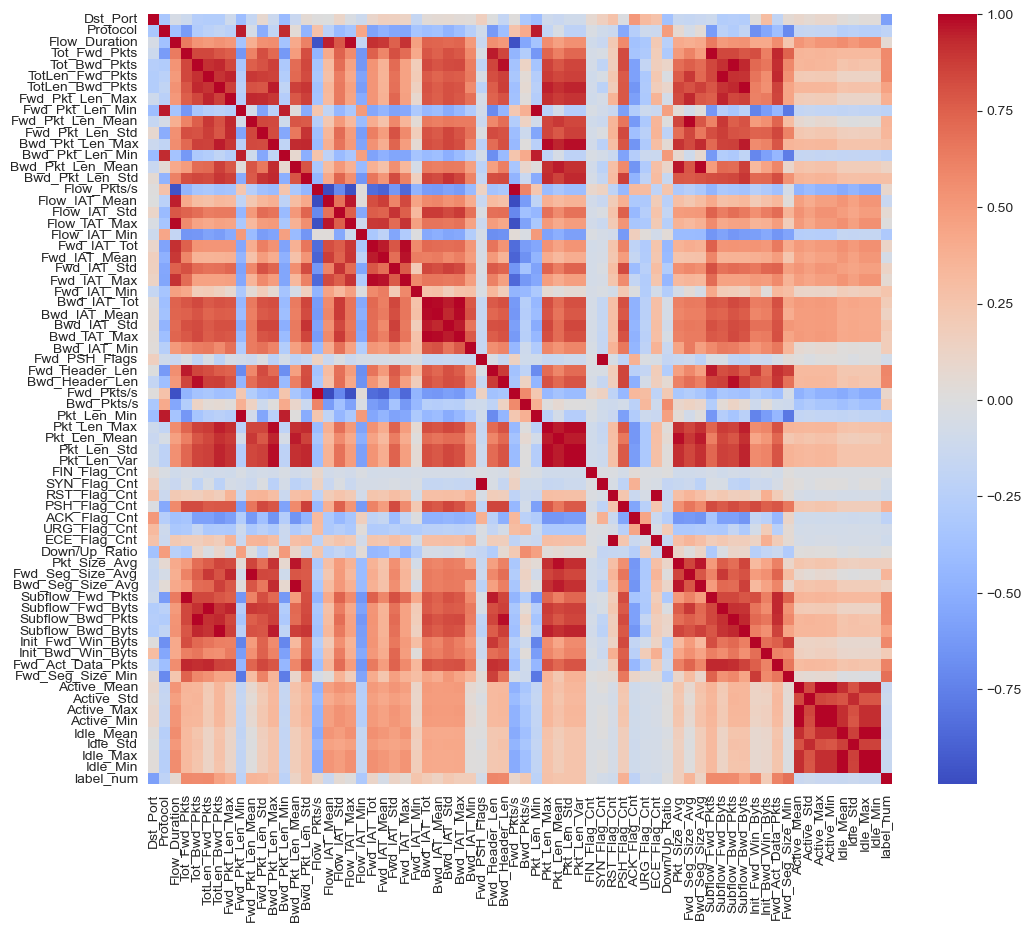

In [112]:
train_corr = IDS2018_RobustScaler.corr(method='spearman')
plt.figure(figsize=(12, 10))

sns.heatmap(train_corr,
            xticklabels=train_corr.columns,
            yticklabels=train_corr.columns,
            cmap="coolwarm")

A simple vista vemos que hay un gran número de variables correlacionadas altamente entre sí.

Para llevar a cabo la selección de características, hemos utilizado recursos online para optimizar nuestro código y aprovechar las ventajas de librerías externas que facilitan la exploración y análisis de nuestro dataset. En particular, hemos empleado la librería autofeatselect de Python, que ofrece herramientas avanzadas para automatizar y acelerar el proceso de selección de variables. 

In [114]:
X = IDS2018_RobustScaler.drop(columns=['label_num'])
y = IDS2018_RobustScaler['label_num']

In [115]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=seed)

In [116]:
# Inicializar el selector de características para clasificación
feat_selector = AutoFeatureSelect(modeling_type='classification', 
                                  X_train=X_train, 
                                  y_train=y_train, 
                                  X_test=X_test, 
                                  y_test=y_test, 
                                  numeric_columns=X.columns.tolist(), 
                                  categorical_columns=[],  # No hay variables categóricas
                                  seed=seed)

In [117]:
# Detectamos variables altamente correlacionadas
corr_feat_selector  = feat_selector.calculate_correlated_features(static_features=None,
                                                            num_threshold=0.9,
                                                            cat_threshold=0.9)

In [118]:
corr_feat_selector

['Tot_Bwd_Pkts',
 'Fwd_PSH_Flags',
 'TotLen_Fwd_Pkts',
 'Tot_Fwd_Pkts',
 'TotLen_Bwd_Pkts',
 'Fwd_Pkt_Len_Mean',
 'Bwd_Pkt_Len_Mean',
 'RST_Flag_Cnt',
 'Bwd_Header_Len',
 'Subflow_Bwd_Pkts',
 'Flow_Pkts/s',
 'Idle_Mean',
 'Pkt_Len_Mean',
 'Flow_Duration',
 'Flow_IAT_Min',
 'Fwd_Header_Len',
 'Flow_IAT_Mean',
 'Fwd_IAT_Mean',
 'Bwd_Pkt_Len_Max',
 'Flow_IAT_Max',
 'Idle_Max',
 'Active_Mean',
 'Fwd_Pkt_Len_Min',
 'Pkt_Size_Avg',
 'Bwd_Pkt_Len_Std',
 'Fwd_Pkt_Len_Max',
 'Pkt_Len_Max',
 'Bwd_IAT_Std']

In [119]:
len(corr_feat_selector)

28

In [120]:
# Eliminamos las variables con correlación alta
feat_selector.drop_correlated_features()

Para identificar las características más importantes entre las restantes, se ha utilizado LightGBM, un método de boosting por gradiente basado en árboles. Hemos escogido LightGBM por su eficiencia, rapidez de entrenamiento, bajo consumo de memoria y capacidad para gestionar grandes volúmenes de datos. Además, aunque sacrificamos algo de interpretabilidad, su capacidad para manejar el desbalanceo de clases es especialmente apropiada para nuestro caso.

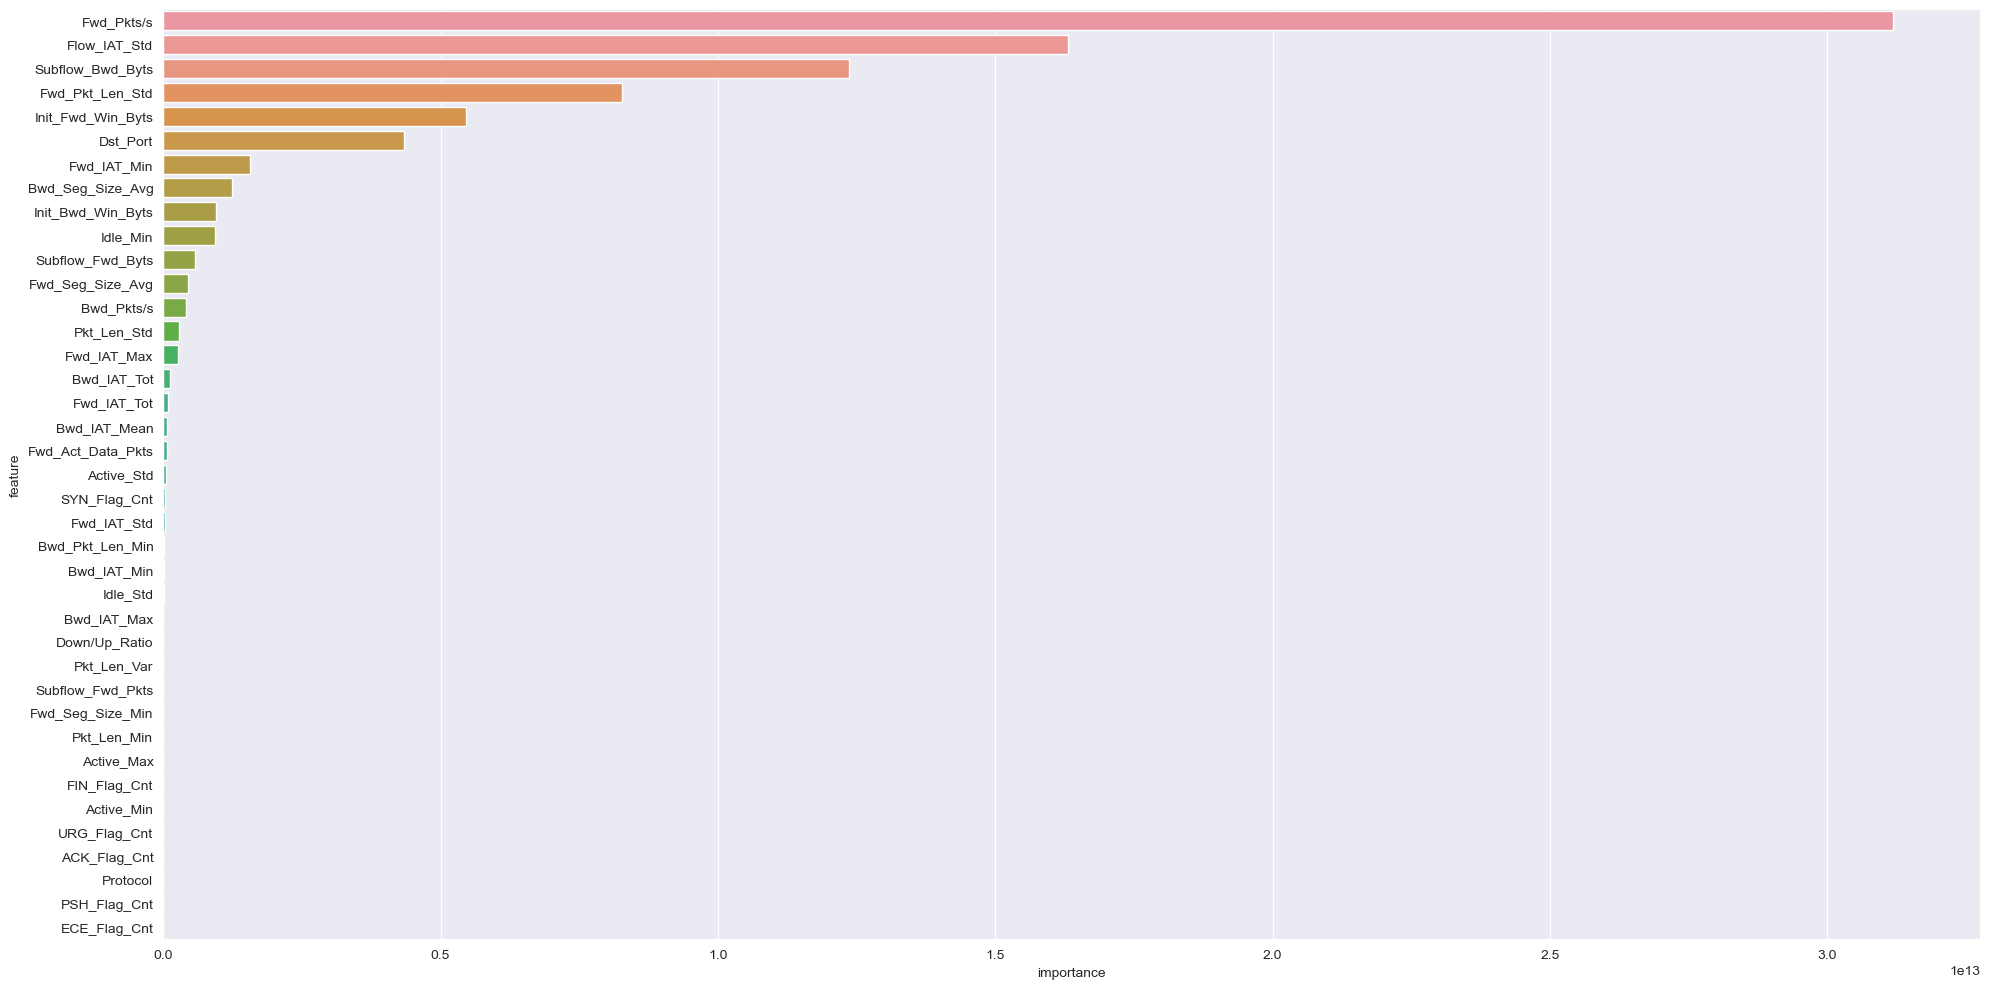

In [122]:
lgbm_importance_df = feat_selector.lgbm_importance(hyperparam_dict=None,
                                                   objective=None,
                                                   return_plot=True)

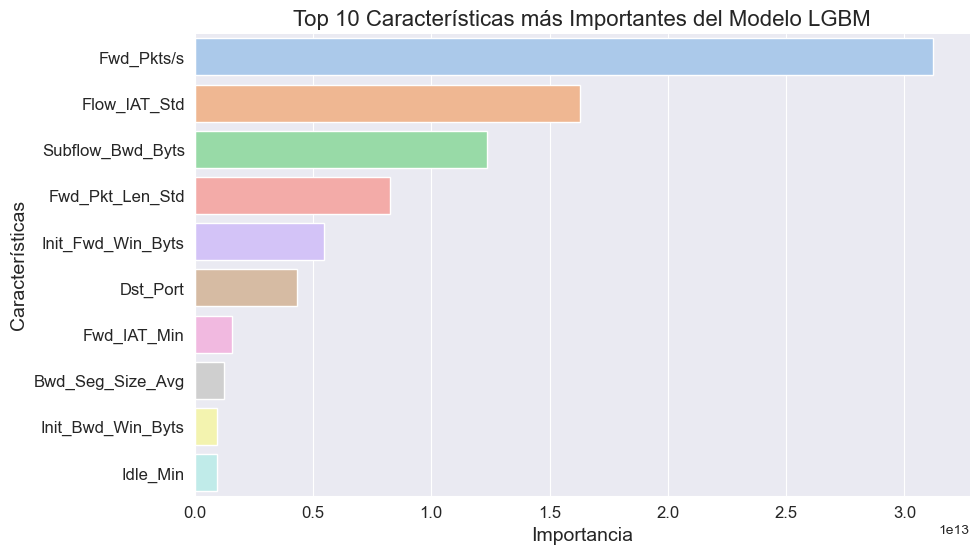

In [173]:
# Crear el gráfico de barras horizontales para la importancia de las características, el top 10

top_10_features = lgbm_importance_df.nlargest(10, 'importance')

plt.figure(figsize=(10, 6))
ax = sns.barplot(y='feature', x='importance', data=top_10_features, palette='pastel')

plt.title('Top 10 Características más Importantes del Modelo LGBM', fontsize=16)


plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Características', fontsize=14)


ax.tick_params(labelsize=12)
sns.despine()
plt.savefig('lgbm.png', dpi=300, bbox_inches='tight')
plt.show()

Usamos más métodos, para seleccionar las variables segun diferentes criterios

In [136]:
#Determine Selection Methods to Apply
#Options: 'lgbm', 'xgb', 'rf','perimp', 'rfecv', 'boruta', 'lassocv'
#Note: Hyperparameters of all methods can be changed
selection_methods = ['lgbm', 'xgb', 'rf']
final_importance  = feat_selector.apply_feature_selection(selection_methods=selection_methods,
                                                            lgbm_hyperparams=None,
                                                            xgb_hyperparams=None,
                                                            rf_hyperparams=None)

#Print Results
final_importance.head(6)

LightGBM Feature Importance is finished
XGBoost Feature Importance is finished
Random Forest Feature Importance is finished


,feature,lgbm_importance,xgb_importance,rf_importance
0,Flow_IAT_Std,1.036225e+13,3.015803e-05,0.009819
1,Fwd_Seg_Size_Avg,1.425036e+12,0.000000e+00,0.023021
2,Fwd_IAT_Min,1.173499e+12,4.806105e-06,0.002150
3,Fwd_Pkts/s,7.720403e+11,1.810822e-03,0.011372
4,Bwd_Pkts/s,3.095250e+11,1.071789e-05,0.026514
5,Fwd_IAT_Max,2.617340e+11,4.924096e-07,0.005723


Los modelos que estás usando son muy eficaces para manejar problemas multiclase. Todos ellos soportan tanto la clasificación binaria como multiclase. De hecho, XGBoost y LightGBM tienen configuraciones específicas para clasificación multiclase, lo que los hace muy adecuados para este tipo de problemas.

In [138]:
lgbm_df  = final_importance[['feature', 'lgbm_importance']].sort_values(by='lgbm_importance', ascending=False)
xgb_df  = final_importance[['feature', 'xgb_importance']].sort_values(by='xgb_importance', ascending=False)
rf_df  = final_importance[['feature', 'rf_importance']].sort_values(by='rf_importance', ascending=False)

# Imprimir los primeros resultados para cada uno
print("LGBM Importance sorted:\n", lgbm_df.head(8))
print("XGBoost Importance sorted:\n", xgb_df.head(6))
print("Random Forest Importance sorted:\n", rf_df.head(6))

LGBM Importance sorted:
             feature  lgbm_importance
0      Flow_IAT_Std     1.036225e+13
1  Fwd_Seg_Size_Avg     1.425036e+12
2       Fwd_IAT_Min     1.173499e+12
3        Fwd_Pkts/s     7.720403e+11
4        Bwd_Pkts/s     3.095250e+11
5       Fwd_IAT_Max     2.617340e+11
6  Subflow_Fwd_Byts     1.913279e+11
7       Pkt_Len_Std     1.390842e+11
XGBoost Importance sorted:
               feature  xgb_importance
21   Fwd_Seg_Size_Min        0.964503
26   Subflow_Bwd_Byts        0.029512
15           Dst_Port        0.003202
3          Fwd_Pkts/s        0.001811
14  Init_Bwd_Win_Byts        0.000644
8         Fwd_IAT_Tot        0.000115
Random Forest Importance sorted:
               feature  rf_importance
15           Dst_Port       0.185296
10  Fwd_Act_Data_Pkts       0.181553
21   Fwd_Seg_Size_Min       0.134910
6    Subflow_Fwd_Byts       0.086725
20  Init_Fwd_Win_Byts       0.081009
22   Subflow_Fwd_Pkts       0.080891


In [8]:
# Se han seleccionado las 7 variables más importantes del método LGBM
selectedLGBM_var7 =  IDS2018_RobustScaler[['label_num',
                                        'Fwd_Pkts/s','Flow_IAT_Std','Subflow_Bwd_Byts','Fwd_Pkt_Len_Std',
                                        'Init_Fwd_Win_Byts','Dst_Port',
                                        'Fwd_IAT_Min']]

<Axes: >

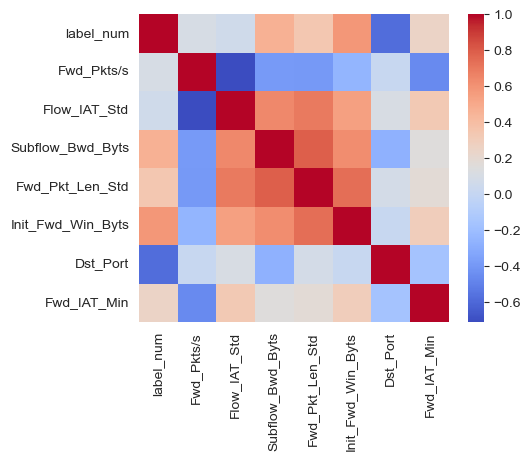

In [141]:
# Correlaciones de las variables seleccionadas
train_corr = selectedLGBM_var7.corr(method='spearman')
plt.figure(figsize=(5,4))

sns.heatmap(train_corr,
            xticklabels=train_corr.columns,
            yticklabels=train_corr.columns,
            cmap="coolwarm")

## 2. KDD - Mineria de datos

### 2.1 Separamos en train, validation y test

Dividimos antes de aplicar técnicas de desbalanceo para evitar el sesgo en los conjuntos que se usan para validar. Si aplicamos técnicas de manejo del desbalanceo (downsampling o upsampling) antes de dividir el dataset en entrenamiento y prueba, estaríamos modificando también el conjunto de prueba. Esto puede llevar a varios problemas, como obtener un conjunto de prueba no representativo o sobreestimar el rendimiento del modelo.

In [11]:

# Separar características y etiquetas
X = selectedLGBM_var7.drop('label_num', axis=1)
y = selectedLGBM_var7['label_num']

# Primero, dividimos en conjunto de prueba (30%) y un conjunto combinado de entrenamiento/validación (70%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

# Luego, dividimos el conjunto de entrenamiento/validación en 80% para entrenamiento y 20% para validación
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=seed, stratify=y_train_val)

# Mostramos el tamaño de los conjuntos
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

# Concatenamos X_train y y_train para manipular el dataset completo (para aplicar downsampling/upsampling)
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

Train shape: (375834, 7)
Validation shape: (93959, 7)
Test shape: (201340, 7)


### 2.2 Tratamiento Desbalanceo de la clase

In [238]:
# MÉTODO 1: Mantener el desbalance de clases
# Este es el conjunto original de entrenamiento (sin cambios)
train_imbalanced = train_data

In [254]:
#Conteo de la clase
counts = train_imbalanced['label_num'].value_counts()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Recuento de cada tipo en la columna 'Label':")
print(counts)

Recuento de cada tipo en la columna 'Label':
0    323137
2     52667
1        30
Name: label_num, dtype: int64


In [32]:
# Dataset por clases
benign = train_data[train_data['label_num'] == 0]
attack_ftp = train_data[train_data['label_num'] == 1]
attack_ssh = train_data[train_data['label_num'] == 2]

In [244]:
# MÉTODO 2: Downsampling (reducir la clase mayoritaria a la clase minoritaria)
# Hacemos downsampling de benignos (clase 0) y SSH (clase 2) al nivel de FTP (clase 1)
benign_downsampled = resample(benign, replace=False, n_samples=len(attack_ftp), random_state=seed)
attack_ssh_downsampled = resample(attack_ssh, replace=False, n_samples=len(attack_ftp), random_state=seed)

# Crear nuevo dataset balanceado (downsampling)
train_downsampled = pd.concat([benign_downsampled, attack_ftp, attack_ssh_downsampled])

In [256]:
#Conteo de la clase
counts = train_downsampled['label_num'].value_counts()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Recuento de cada tipo en la columna 'Label':")
print(counts)

Recuento de cada tipo en la columna 'Label':
0    30
1    30
2    30
Name: label_num, dtype: int64


In [40]:
# MÉTODO 3 A: Upsampling (aumentar las clases minoritarias al tamaño de la mayoritaria)
# Hacemos upsampling de FTP (clase 1) y SSH (clase 2) al nivel de benigno (clase 0)
attack_ftp_upsampled = resample(attack_ftp, replace=True, n_samples=len(benign), random_state=seed)
attack_ssh_upsampled = resample(attack_ssh, replace=True, n_samples=len(benign), random_state=seed)

# Crear nuevo dataset balanceado (upsampling)
train_upsampled = pd.concat([benign, attack_ftp_upsampled, attack_ssh_upsampled])

In [258]:
#Conteo de la clase
counts = train_upsampled['label_num'].value_counts()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Recuento de cada tipo en la columna 'Label':")
print(counts)

Recuento de cada tipo en la columna 'Label':
0    323137
1    323137
2    323137
Name: label_num, dtype: int64


In [26]:
# MÉTODO 3 B: Upsampling (aumentar las clases minoritarias al tamaño de la mayoritaria) CON SMOTE
# Hacemos upsampling de FTP (clase 1) y SSH (clase 2) al nivel de benigno (clase 0)

# Aplicar SMOTE para aumentar las clases minoritarias
smote = SMOTE(random_state=seed)
X_resampled, y_resampled = smote.fit_resample(train_data.drop('label_num', axis=1), train_data['label_num'])

# Convertimos X_resampled y y_resampled de nuevo en DataFrames para poder concatenarlos si es necesario
X_resampled_df = pd.DataFrame(X_resampled, columns=train_data.drop('label_num', axis=1).columns)  # Asegurar que usamos las mismas columnas de 'train_data'
y_resampled_df = pd.DataFrame(y_resampled, columns=['label_num'])

# Crear nuevo dataset balanceado
train_upsampled_smote = pd.concat([X_resampled_df, y_resampled_df], axis=1)

In [27]:
#Conteo de la clase
counts = train_upsampled_smote['label_num'].value_counts()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Recuento de cada tipo en la columna 'Label':")
print(counts)

Recuento de cada tipo en la columna 'Label':
0    323137
2    323137
1    323137
Name: label_num, dtype: int64


In [25]:
# MÉTODO 4 A: Upsampling (aumentar las clases minoritaria al tamaño de la mediana), Downsampling (mayoritaria a la mediana)
# Hacemos upsampling de FTP (clase 1) y SSH (clase 2) al nivel de benigno (clase 0)
attack_ftp_upsampled = resample(attack_ftp, replace=True, n_samples=len(attack_ssh), random_state=seed)
benign_downsampled = resample(benign, replace=False, n_samples=len(attack_ssh), random_state=seed)
# Crear nuevo dataset balanceado (upsampling)
train_mix = pd.concat([benign_downsampled, attack_ftp_upsampled, attack_ssh])

In [27]:
#Conteo de la clase
counts = train_mix['label_num'].value_counts()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Recuento de cada tipo en la columna 'Label':")
print(counts)

Recuento de cada tipo en la columna 'Label':
0    52667
1    52667
2    52667
Name: label_num, dtype: int64


#### 2.2.1 Guardado intermedio 2

In [252]:
train_imbalanced.to_csv('train_imbalanced.csv', sep=';', index=False, header=True)
train_downsampled.to_csv('train_downsampled.csv', sep=';', index=False, header=True)
train_upsampled.to_csv('train_upsampled.csv', sep=';', index=False, header=True)
train_upsampled_smote.to_csv('train_upsampled.csv', sep=';', index=False, header=True)
train_mix.to_csv('train_mix.csv', sep=';', index=False, header=True)
val_data.to_csv('val_data_LGBM_var7.csv', sep=';', index=False, header=True)
test_data.to_csv('test_data_var7.csv', sep=';', index=False, header=True)

### 2.3 Aplicación de algoritmos ML

In [100]:
#Lecturas
train_imbalanced = pd.read_csv(ruta_intermedia + 'train_imbalanced.csv', sep =';')
train_downsampled = pd.read_csv(ruta_intermedia + 'train_downsampled.csv', sep =';')
train_upsampled = pd.read_csv(ruta_intermedia + 'train_upsampled.csv', sep =';')
train_upsampled_smote = pd.read_csv(ruta_intermedia + 'train_upsampled_smote.csv', sep =';')
train_mix = pd.read_csv(ruta_intermedia + 'train_mix.csv', sep =';')
val_data = pd.read_csv(ruta_intermedia + 'val_data_LGBM_var7.csv', sep =';')
test_data = pd.read_csv(ruta_intermedia + 'test_data_var7.csv', sep =';')

In [101]:
# Separar características y etiquetas
X_train_inbalanced = train_imbalanced.drop('label_num', axis=1)
y_train_inbalanced = train_imbalanced['label_num']


X_train_downsampled = train_downsampled.drop('label_num', axis=1)
y_train_downsampled = train_downsampled['label_num']


X_train_upsampled = train_upsampled.drop('label_num', axis=1)
y_train_upsampled = train_upsampled['label_num']

X_train_upsampled_smote = train_upsampled_smote.drop('label_num', axis=1)
y_train_upsampled_smote = train_upsampled_smote['label_num']

X_train_mix = train_mix.drop('label_num', axis=1)
y_train_mix = train_mix['label_num']

X_val = val_data.drop('label_num', axis=1)
y_val = val_data['label_num']


X_test = test_data.drop('label_num', axis=1)
y_test = test_data['label_num']

Cuando se trata de algoritmos que no tienen en cuenta el orden de las clases, es fundamental elegir aquellos que traten las etiquetas como categorías discretas y no numéricas continuas. Algoritmos que NO tienen en cuenta el orden (Categorías Discretas):

    DecisionTreeClassifier: Este algoritmo trata las etiquetas como categorías discretas, ya que las decisiones se basan en divisiones de características, no en un orden inherente en la etiqueta.
    RandomForestClassifier: Similar a los árboles de decisión, es adecuado porque combina múltiples árboles de decisión que no tienen en cuenta el orden de las etiquetas.
    GradientBoostingClassifier: Aunque es un método de boosting, sigue usando árboles de decisión que no consideran el orden de las etiquetas.
    LogisticRegression: A pesar del nombre, trata las clases como categorías discretas (multiclase en este caso) y no asume un orden entre ellas.
    KNeighborsClassifier: Clasifica en función de la distancia a los vecinos más cercanos, por lo que no asume ningún orden entre las clases.
    SVC (Support Vector Classifier): Aunque SVM puede usarse para problemas de regresión, el clasificador en su versión estándar trata las etiquetas como categorías discretas, no ordenadas.

Algoritmos que sí tienen en cuenta el orden (NO recomendados):

    RidgeClassifier: Utiliza una variante de regresión lineal, lo que implica un tratamiento continuo y considera una relación de orden entre las etiquetas.
    LinearSVC: A diferencia de SVC, LinearSVC puede interpretar las etiquetas de manera más continua, dado que optimiza un clasificador lineal que puede verse influido por el valor numérico de las etiquetas.

Las características no son independientes entre sí,por tanto descartamos aquellos que asumen independencia entre características, como gaussian_nb.

In [47]:
# Lista de clasificadores
classifiers = [
    ('decision_tree', DecisionTreeClassifier(random_state=seed)),
    ('random_forest', RandomForestClassifier(random_state=seed)),
    ('gradient_boosting', GradientBoostingClassifier(random_state=seed)),
    ('logistic_regression', LogisticRegression(random_state=seed)),
    ('knn', KNeighborsClassifier()),
    ('svc', SVC())
]

# Creación de pipelines para cada clasificador
pipelines = [(name, Pipeline([(name, clf)])) for name, clf in classifiers]

#### 2.3.1 INBALANCE

##### 2.3.1.1 Elección mejores modelos

In [216]:
# Evaluación de los modelos con el conjunto de validación
scores = {}
times = {}
detailed_metrics = {}

for name, pipeline in pipelines:
    
    start_time = time.time()
    
    # Entrenamiento del modelo
    pipeline.fit(X_train_inbalanced, y_train_inbalanced)
    
    # Medir el tiempo transcurrido desde el inicio del entrenamiento
    training_time = time.time() - start_time
    
    # Predicciones en el conjunto de validación
    y_val_pred = pipeline.predict(X_val)
    y_val_proba = pipeline.predict_proba(X_val) if hasattr(pipeline, 'predict_proba') else None
    
    # Evaluación del modelo
    accuracy = pipeline.score(X_val, y_val)
    balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
    class_report = classification_report(y_val, y_val_pred, output_dict=True)  # Obtener como diccionario para analizar mejor
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    # Si predict_proba está disponible, calcular ROC-AUC
    roc_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr') if y_val_proba is not None else None

    # Guardar las métricas
    scores[name] = accuracy
    times[name] = training_time
    detailed_metrics[name] = {
        'Balanced Accuracy': balanced_acc,
        'Precision (weighted)': class_report['weighted avg']['precision'],
        'Recall (weighted)': class_report['weighted avg']['recall'],
        'F1-Score (weighted)': class_report['weighted avg']['f1-score'],
        'Confusion Matrix': conf_matrix,
        'ROC-AUC': roc_auc
    }

    # Mostrar resultados
    print(f"\n{name}:")
    print(f"  Accuracy = {accuracy:.4f}")
    print(f"  Balanced Accuracy = {balanced_acc:.4f}")
    print(f"  Precision (weighted) = {class_report['weighted avg']['precision']:.4f}")
    print(f"  Recall (weighted) = {class_report['weighted avg']['recall']:.4f}")
    print(f"  F1-Score (weighted) = {class_report['weighted avg']['f1-score']:.4f}")
    if roc_auc is not None:
        print(f"  ROC-AUC = {roc_auc:.4f}")
    print(f"  Tiempo de entrenamiento = {training_time:.4f} segundos")
    print(f"  Matriz de Confusión:\n{conf_matrix}")


decision_tree:
  Accuracy = 1.0000
  Balanced Accuracy = 0.9999
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 0.9999
  Tiempo de entrenamiento = 0.4990 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    3     1 13163]]

random_forest:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 25.1730 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    0     1 13166]]

gradient_boosting:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 223.4246 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    0     1 13166]]


C:\Users\AIZANE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



logistic_regression:
  Accuracy = 0.9968
  Balanced Accuracy = 0.6648
  Precision (weighted) = 0.9967
  Recall (weighted) = 0.9968
  F1-Score (weighted) = 0.9967
  ROC-AUC = 0.9977
  Tiempo de entrenamiento = 18.2411 segundos
  Matriz de Confusión:
[[80518     1   266]
 [    7     0     0]
 [   30     0 13137]]

knn:
  Accuracy = 0.9996
  Balanced Accuracy = 0.8088
  Precision (weighted) = 0.9996
  Recall (weighted) = 0.9996
  F1-Score (weighted) = 0.9996
  ROC-AUC = 0.9519
  Tiempo de entrenamiento = 2.5680 segundos
  Matriz de Confusión:
[[80779     1     5]
 [    4     3     0]
 [   28     0 13139]]

svc:
  Accuracy = 0.8598
  Balanced Accuracy = 0.3333
  Precision (weighted) = 0.7392
  Recall (weighted) = 0.8598
  F1-Score (weighted) = 0.7950
  Tiempo de entrenamiento = 4888.5137 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    7     0     0]
 [13167     0     0]]


C:\Users\AIZANE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIZANE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIZANE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### 2.3.1.2 Ajuste hiperparámetros

Seleccionamos los dos mejores modelos Decision Tree y Random Forest; y ajustamos los hiperparametros. 

Decision Tree 

In [18]:
# Parrilla de hiperparámetros para Decision Tree
param_grid_decisiontree_inbalanced = {
    'max_depth': [3, 5, 10, 20],# Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],# Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],# Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy'], # Agregamos los criterios que usa el DecisionTree
    'class_weight': ['balanced', None]  # Agregar el parámetro para equilibrar las clases automáticamente
}

# Realizar GridSearchCV
grid_search_decisiontree_inbalanced = GridSearchCV(DecisionTreeClassifier(random_state=seed), param_grid_decisiontree_inbalanced, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_decisiontree_inbalanced.fit(X_train_inbalanced, y_train_inbalanced)

# Mejor conjunto de hiperparámetros
print("Best parameters found: ", grid_search_decisiontree_inbalanced.best_params_)

# Evaluar el mejor modelo en el conjunto de validación
best_model_decisiontree_inbalanced = grid_search_decisiontree_inbalanced.best_estimator_
y_val_pred_decisiontree_inbalanced = best_model_decisiontree_inbalanced.predict(X_val)
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred_decisiontree_inbalanced):.4f}")

Best parameters found:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation accuracy: 1.0000


In [46]:
# Guardar el modelo entrenado
joblib.dump(best_model_decisiontree_inbalanced, 'decision_tree_inbalanced_model.pkl')
print("Modelo guardado con éxito.")

Modelo guardado con éxito.


Random Forest

In [109]:
# Parrilla de hiperparámetros para Random Forest
param_grid_rf_inbalanced = {
    'n_estimators': [1, 10, 20, 50],  # Número de árboles en el bosque
    'max_depth': [3, 5, 10, 15],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],    # Mínimo número de muestras en un nodo hoja
    'bootstrap': [True, False]        # Usar o no bootstrap
}

# Realizar GridSearchCV para Random Forest
grid_search_rf_inbalanced = GridSearchCV(RandomForestClassifier(random_state=seed), param_grid_rf_inbalanced, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_rf_inbalanced.fit(X_train_inbalanced, y_train_inbalanced)

# Mejor conjunto de hiperparámetros
print("Best parameters found: ", grid_search_rf_inbalanced.best_params_)

# Evaluar el mejor modelo en el conjunto de validación
best_model_rf_inbalanced = grid_search_rf_inbalanced.best_estimator_
y_val_pred_rf_inbalanced = best_model_rf_inbalanced.predict(X_val)
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred_rf_inbalanced):.4f}")


Best parameters found:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20}
Validation accuracy: 1.0000


In [110]:
# Guardar el modelo entrenado
joblib.dump(best_model_rf_inbalanced, 'rf_inbalanced_model.pkl')
print("Modelo guardado con éxito.")

Modelo guardado con éxito.


#### 2.3.2 DOWNSAMPLIG

##### 2.3.2.1 Elección mejores modelos

In [226]:
# Evaluación de los modelos con el conjunto de validación
scores = {}
times = {}
detailed_metrics = {}

for name, pipeline in pipelines:
    # Medir el tiempo de entrenamiento y evaluación
    start_time = time.time()
    
    # Entrenamiento del modelo
    pipeline.fit(X_train_downsampled, y_train_downsampled)
    
    # Medir el tiempo transcurrido desde el inicio del entrenamiento
    training_time = time.time() - start_time
    
    # Predicciones en el conjunto de validación
    y_val_pred = pipeline.predict(X_val)
    y_val_proba = pipeline.predict_proba(X_val) if hasattr(pipeline, 'predict_proba') else None
    
    # Evaluación del modelo
    accuracy = pipeline.score(X_val, y_val)
    balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
    class_report = classification_report(y_val, y_val_pred, output_dict=True)  # Obtener como diccionario para analizar mejor
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    # Si predict_proba está disponible, calcular ROC-AUC
    roc_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr') if y_val_proba is not None else None

    # Guardar las métricas
    scores[name] = accuracy
    times[name] = training_time
    detailed_metrics[name] = {
        'Balanced Accuracy': balanced_acc,
        'Precision (weighted)': class_report['weighted avg']['precision'],
        'Recall (weighted)': class_report['weighted avg']['recall'],
        'F1-Score (weighted)': class_report['weighted avg']['f1-score'],
        'Confusion Matrix': conf_matrix,
        'ROC-AUC': roc_auc
    }

    # Mostrar resultados
    print(f"\n{name}:")
    print(f"  Accuracy = {accuracy:.4f}")
    print(f"  Balanced Accuracy = {balanced_acc:.4f}")
    print(f"  Precision (weighted) = {class_report['weighted avg']['precision']:.4f}")
    print(f"  Recall (weighted) = {class_report['weighted avg']['recall']:.4f}")
    print(f"  F1-Score (weighted) = {class_report['weighted avg']['f1-score']:.4f}")
    if roc_auc is not None:
        print(f"  ROC-AUC = {roc_auc:.4f}")
    print(f"  Tiempo de entrenamiento = {training_time:.4f} segundos")
    print(f"  Matriz de Confusión:\n{conf_matrix}")


decision_tree:
  Accuracy = 0.9813
  Balanced Accuracy = 0.9927
  Precision (weighted) = 0.9990
  Recall (weighted) = 0.9813
  F1-Score (weighted) = 0.9900
  ROC-AUC = 0.9932
  Tiempo de entrenamiento = 0.0080 segundos
  Matriz de Confusión:
[[79031  1667    87]
 [    0     7     0]
 [    0     1 13166]]

random_forest:
  Accuracy = 0.9986
  Balanced Accuracy = 0.9988
  Precision (weighted) = 0.9993
  Recall (weighted) = 0.9986
  F1-Score (weighted) = 0.9989
  ROC-AUC = 0.9999
  Tiempo de entrenamiento = 0.2330 segundos
  Matriz de Confusión:
[[80687    69    29]
 [    0     7     0]
 [   29     1 13137]]

gradient_boosting:
  Accuracy = 0.9819
  Balanced Accuracy = 0.9924
  Precision (weighted) = 0.9996
  Recall (weighted) = 0.9819
  F1-Score (weighted) = 0.9906
  ROC-AUC = 0.9902
  Tiempo de entrenamiento = 0.4110 segundos
  Matriz de Confusión:
[[79117  1667     1]
 [    0     7     0]
 [   29     1 13137]]


C:\Users\AIZANE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



logistic_regression:
  Accuracy = 0.9846
  Balanced Accuracy = 0.9934
  Precision (weighted) = 0.9886
  Recall (weighted) = 0.9846
  F1-Score (weighted) = 0.9863
  ROC-AUC = 0.9896
  Tiempo de entrenamiento = 0.0380 segundos
  Matriz de Confusión:
[[79369   295  1121]
 [    0     7     0]
 [   29     1 13137]]

knn:
  Accuracy = 0.8746
  Balanced Accuracy = 0.9507
  Precision (weighted) = 0.9877
  Recall (weighted) = 0.8746
  F1-Score (weighted) = 0.9259
  ROC-AUC = 0.9894
  Tiempo de entrenamiento = 0.0100 segundos
  Matriz de Confusión:
[[69030 10502  1253]
 [    0     7     0]
 [    5    25 13137]]

svc:
  Accuracy = 0.1863
  Balanced Accuracy = 0.3512
  Precision (weighted) = 0.8806
  Recall (weighted) = 0.1863
  F1-Score (weighted) = 0.1240
  Tiempo de entrenamiento = 0.0070 segundos
  Matriz de Confusión:
[[ 4341  1057 75387]
 [    0     0     7]
 [    0     0 13167]]


##### 2.3.2.2 Ajuste hiperparámetros

Seleccionamos el mejor modelo Random Forest; y ajustamos los hiperparametros.

In [62]:
# Parrilla de hiperparámetros para Decision Tree
param_grid_decisiontree_downsampling = {
    'max_depth': [3, 5, 10, 20],# Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],# Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],# Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy'], # Agregamos los criterios que usa el DecisionTree
    'class_weight': ['balanced', None]  # Agregar el parámetro para equilibrar las clases automáticamente
}

# Realizar GridSearchCV
grid_search_decisiontree_downsampling= GridSearchCV(DecisionTreeClassifier(random_state=seed), param_grid_decisiontree_downsampling, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_decisiontree_downsampling.fit(X_train_downsampled, y_train_downsampled)

# Mejor conjunto de hiperparámetros
print("Best parameters found: ", grid_search_decisiontree_downsampling.best_params_)

# Evaluar el mejor modelo en el conjunto de validación
best_model_decisiontree_downsampling = grid_search_decisiontree_downsampling.best_estimator_
y_val_pred_decisiontree_downsampling= best_model_decisiontree_downsampling.predict(X_val)
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred_decisiontree_downsampling):.4f}")

Best parameters found:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation accuracy: 0.9813


In [63]:
# Guardar el modelo entrenado
joblib.dump(best_model_decisiontree_downsampling, 'dtc_downsampled_model.pkl')
print("Modelo guardado con éxito.")

Modelo guardado con éxito.


In [69]:
# Definir parrilla de hiperparámetros para Random Forest
param_grid_rf_downsampling = {
    'n_estimators': [1, 10, 20, 50],  # Número de árboles en el bosque
    'max_depth': [3, 5, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],    # Mínimo número de muestras en un nodo hoja
    'bootstrap': [True, False]        # Usar o no bootstrap
}

# Realizar GridSearchCV para Random Forest
grid_search_rf_downsampling = GridSearchCV(RandomForestClassifier(random_state=seed), param_grid_rf_downsampling, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_rf_downsampling.fit(X_train_downsampled, y_train_downsampled)#

# Mejor conjunto de hiperparámetros
print("Best parameters found: ", grid_search_rf_downsampling.best_params_)

# Evaluar el mejor modelo en el conjunto de validación
best_model_rf_downsampling = grid_search_rf_downsampling.best_estimator_
y_val_pred_rf_downsampling = best_model_rf_downsampling.predict(X_val)
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred_rf_downsampling):.4f}")


Best parameters found:  {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Validation accuracy: 0.9781


In [70]:
# Guardar el modelo entrenado
joblib.dump(best_model_rf_downsampling, 'rf_downsampled_model.pkl')
print("Modelo guardado con éxito.")

Modelo guardado con éxito.


knn

In [72]:
# Parrilla de hiperparámetros para KNN
param_grid_knn_downsampling = {
    'n_neighbors': [3, 5, 10],       # Número de vecinos
    'weights': ['uniform', 'distance'],  # Ponderación de los vecinos
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Métrica de distancia
    'p': [1, 2]  # Parámetro para la distancia de Minkowski (p=1: Manhattan, p=2: Euclídea)
}

# Realizar GridSearchCV para KNN
grid_search_knn_downsampling = GridSearchCV(KNeighborsClassifier(), param_grid_knn_downsampling, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_knn_downsampling.fit(X_train_downsampled, y_train_downsampled)

# Mejor conjunto de hiperparámetros
print("Best parameters found: ", grid_search_knn_downsampling.best_params_)

# Evaluar el mejor modelo en el conjunto de validación
best_model_knn_downsampling = grid_search_knn_downsampling.best_estimator_
y_val_pred_knn_downsampling = best_model_knn_downsampling.predict(X_val)
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred_knn_downsampling):.4f}")


Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Validation accuracy: 0.9554


In [73]:
# Guardar el modelo entrenado
joblib.dump(best_model_knn_downsampling, 'best_model_knn_downsampling.pkl')
print("Modelo guardado con éxito.")

Modelo guardado con éxito.


#### 2.3.3 UPSAMPLING

##### 2.3.3.1 Elección mejores modelos

Método A

In [ ]:
# Evaluación de los modelos con el conjunto de validación
scores = {}
times = {}
detailed_metrics = {}

for name, pipeline in pipelines:
    # Medir el tiempo de entrenamiento y evaluación
    start_time = time.time()
    
    # Entrenamiento del modelo
    pipeline.fit(X_train_upsampled, y_train_upsampled)
    
    # Medir el tiempo transcurrido desde el inicio del entrenamiento
    training_time = time.time() - start_time
    
    # Predicciones en el conjunto de validación
    y_val_pred = pipeline.predict(X_val)
    y_val_proba = pipeline.predict_proba(X_val) if hasattr(pipeline, 'predict_proba') else None
    
    # Evaluación del modelo
    accuracy = pipeline.score(X_val, y_val)
    balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
    class_report = classification_report(y_val, y_val_pred, output_dict=True)  # Obtener como diccionario para analizar mejor
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    # Si predict_proba está disponible, calcular ROC-AUC
    roc_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr') if y_val_proba is not None else None

    # Guardar las métricas
    scores[name] = accuracy
    times[name] = training_time
    detailed_metrics[name] = {
        'Balanced Accuracy': balanced_acc,
        'Precision (weighted)': class_report['weighted avg']['precision'],
        'Recall (weighted)': class_report['weighted avg']['recall'],
        'F1-Score (weighted)': class_report['weighted avg']['f1-score'],
        'Confusion Matrix': conf_matrix,
        'ROC-AUC': roc_auc
    }

    # Mostrar resultados
    print(f"\n{name}:")
    print(f"  Accuracy = {accuracy:.4f}")
    print(f"  Balanced Accuracy = {balanced_acc:.4f}")
    print(f"  Precision (weighted) = {class_report['weighted avg']['precision']:.4f}")
    print(f"  Recall (weighted) = {class_report['weighted avg']['recall']:.4f}")
    print(f"  F1-Score (weighted) = {class_report['weighted avg']['f1-score']:.4f}")
    if roc_auc is not None:
        print(f"  ROC-AUC = {roc_auc:.4f}")
    print(f"  Tiempo de entrenamiento = {training_time:.4f} segundos")
    print(f"  Matriz de Confusión:\n{conf_matrix}")


decision_tree:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 2.3310 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    0     1 13166]]

random_forest:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 62.6506 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    0     1 13166]]

gradient_boosting:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 482.4851 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    0     1 13166]]


C:\Users\AIZANE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



logistic_regression:
  Accuracy = 0.9954
  Balanced Accuracy = 0.9976
  Precision (weighted) = 0.9985
  Recall (weighted) = 0.9954
  F1-Score (weighted) = 0.9969
  ROC-AUC = 0.9975
  Tiempo de entrenamiento = 33.1308 segundos
  Matriz de Confusión:
[[80379   297   109]
 [    0     7     0]
 [   29     1 13137]]

knn:
  Accuracy = 0.9993
  Balanced Accuracy = 0.9040
  Precision (weighted) = 0.9993
  Recall (weighted) = 0.9993
  F1-Score (weighted) = 0.9993
  ROC-AUC = 0.9519
  Tiempo de entrenamiento = 4.9930 segundos
  Matriz de Confusión:
[[80742     5    38]
 [    1     5     1]
 [   21     1 13145]]


In [ ]:
# He dejado más de 24h ejecuntando y no ha terminado de ejecutarse el modelo SVC

Método B - SMOTE

In [ ]:
# Evaluación de los modelos con el conjunto de validación
scores = {}
times = {}
detailed_metrics = {}

for name, pipeline in pipelines:
    # Medir el tiempo de entrenamiento y evaluación
    start_time = time.time()
    
    # Entrenamiento del modelo
    pipeline.fit(X_train_upsampled_smote, y_train_upsampled_smote)
    
    # Medir el tiempo transcurrido desde el inicio del entrenamiento
    training_time = time.time() - start_time
    
    # Predicciones en el conjunto de validación
    y_val_pred = pipeline.predict(X_val)
    y_val_proba = pipeline.predict_proba(X_val) if hasattr(pipeline, 'predict_proba') else None
    
    # Evaluación del modelo
    accuracy = pipeline.score(X_val, y_val)
    balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
    class_report = classification_report(y_val, y_val_pred, output_dict=True)  # Obtener como diccionario para analizar mejor
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    # Si predict_proba está disponible, calcular ROC-AUC
    roc_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr') if y_val_proba is not None else None

    # Guardar las métricas
    scores[name] = accuracy
    times[name] = training_time
    detailed_metrics[name] = {
        'Balanced Accuracy': balanced_acc,
        'Precision (weighted)': class_report['weighted avg']['precision'],
        'Recall (weighted)': class_report['weighted avg']['recall'],
        'F1-Score (weighted)': class_report['weighted avg']['f1-score'],
        'Confusion Matrix': conf_matrix,
        'ROC-AUC': roc_auc
    }

    # Mostrar resultados
    print(f"\n{name}:")
    print(f"  Accuracy = {accuracy:.4f}")
    print(f"  Balanced Accuracy = {balanced_acc:.4f}")
    print(f"  Precision (weighted) = {class_report['weighted avg']['precision']:.4f}")
    print(f"  Recall (weighted) = {class_report['weighted avg']['recall']:.4f}")
    print(f"  F1-Score (weighted) = {class_report['weighted avg']['f1-score']:.4f}")
    if roc_auc is not None:
        print(f"  ROC-AUC = {roc_auc:.4f}")
    print(f"  Tiempo de entrenamiento = {training_time:.4f} segundos")
    print(f"  Matriz de Confusión:\n{conf_matrix}")


decision_tree:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 3.1860 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    0     1 13166]]

random_forest:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 104.9404 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    0     1 13166]]

gradient_boosting:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 732.2357 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    0     1 13166]]


C:\Users\AIZANE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



logistic_regression:
  Accuracy = 0.9950
  Balanced Accuracy = 0.9974
  Precision (weighted) = 0.9981
  Recall (weighted) = 0.9950
  F1-Score (weighted) = 0.9965
  ROC-AUC = 0.9975
  Tiempo de entrenamiento = 43.4590 segundos
  Matriz de Confusión:
[[80347   287   151]
 [    0     7     0]
 [   26     4 13137]]

knn:
  Accuracy = 0.9993
  Balanced Accuracy = 0.9992
  Precision (weighted) = 0.9994
  Recall (weighted) = 0.9993
  F1-Score (weighted) = 0.9994
  ROC-AUC = 0.9997
  Tiempo de entrenamiento = 8.0030 segundos
  Matriz de Confusión:
[[80750    10    25]
 [    0     7     0]
 [   25     2 13140]]


In [ ]:
# He dejado más de 24h ejecuntando y no ha terminado de ejecutarse el modelo SVC

##### 2.3.3.2 Ajuste hiperparámetros

Seleccionamos mejores modelos y ajustamos los hiperparametros.

Método A

In [119]:
# Parrilla de hiperparámetros para el árbol de decisión
param_grid_decisiontree_upsampling = {
    'max_depth': [3, 5, 10, 20],# Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],# Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],# Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy']  # Agregamos los criterios que usa el DecisionTree
}

# Realizar GridSearchCV
grid_search_decisiontree_upsampling = GridSearchCV(DecisionTreeClassifier(random_state=seed), param_grid_decisiontree_upsampling, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_decisiontree_upsampling.fit(X_train_upsampled, y_train_upsampled)

# Mejor conjunto de hiperparámetros
print("Best parameters found: ", grid_search_decisiontree_upsampling.best_params_)

# Evaluar el mejor modelo en el conjunto de validación
best_model_decisiontree_upsampling = grid_search_decisiontree_upsampling.best_estimator_
y_val_pred_decisiontree_upsampling = best_model_decisiontree_upsampling.predict(X_val)
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred_decisiontree_upsampling):.4f}")

Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation accuracy: 1.0000


In [120]:
# Guardar el modelo entrenado
joblib.dump(best_model_decisiontree_upsampling, '_decisiontree_upsampling_model.pkl')
print("Modelo guardado con éxito.")

Modelo guardado con éxito.


Método B

In [11]:
# Parrilla de hiperparámetros para el árbol de decisión
param_grid_decisiontree_upsampling_smote = {
    'max_depth': [3, 5, 10, 20],# Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],# Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],# Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy']  # Agregamos los criterios que usa el DecisionTree
}

# Realizar GridSearchCV
grid_search_decisiontree_upsampling_smote = GridSearchCV(DecisionTreeClassifier(random_state=seed), param_grid_decisiontree_upsampling_smote, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_decisiontree_upsampling_smote.fit(X_train_upsampled_smote, y_train_upsampled_smote)

# Mejor conjunto de hiperparámetros
print("Best parameters found: ", grid_search_decisiontree_upsampling_smote.best_params_)

# Evaluar el mejor modelo en el conjunto de validación
best_model_decisiontree_upsampling_smote = grid_search_decisiontree_upsampling_smote.best_estimator_
y_val_pred_decisiontree_upsampling_smote = best_model_decisiontree_upsampling_smote.predict(X_val)
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred_decisiontree_upsampling_smote):.4f}")

Best parameters found:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation accuracy: 1.0000


In [12]:
# Guardar el modelo entrenado
joblib.dump(best_model_decisiontree_upsampling_smote, 'decisiontree_upsampling_smote_model.pkl')
print("Modelo guardado con éxito.")

Modelo guardado con éxito.


#### 2.3.4 MIX

##### 2.3.4.1 Elección mejores modelos

In [15]:
# Evaluación de los modelos con el conjunto de validación
scores = {}
times = {}
detailed_metrics = {}

for name, pipeline in pipelines:
    
    start_time = time.time()
    
    # Entrenamiento del modelo
    pipeline.fit(X_train_mix, y_train_mix)
    
    # Medir el tiempo transcurrido desde el inicio del entrenamiento
    training_time = time.time() - start_time
    
    # Predicciones en el conjunto de validación
    y_val_pred = pipeline.predict(X_val)
    y_val_proba = pipeline.predict_proba(X_val) if hasattr(pipeline, 'predict_proba') else None
    
    # Evaluación del modelo
    accuracy = pipeline.score(X_val, y_val)
    balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
    class_report = classification_report(y_val, y_val_pred, output_dict=True)  # Obtener como diccionario para analizar mejor
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    # Si predict_proba está disponible, calcular ROC-AUC
    roc_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr') if y_val_proba is not None else None

    # Guardar las métricas
    scores[name] = accuracy
    times[name] = training_time
    detailed_metrics[name] = {
        'Balanced Accuracy': balanced_acc,
        'Precision (weighted)': class_report['weighted avg']['precision'],
        'Recall (weighted)': class_report['weighted avg']['recall'],
        'F1-Score (weighted)': class_report['weighted avg']['f1-score'],
        'Confusion Matrix': conf_matrix,
        'ROC-AUC': roc_auc
    }

    # Mostrar resultados
    print(f"\n{name}:")
    print(f"  Accuracy = {accuracy:.4f}")
    print(f"  Balanced Accuracy = {balanced_acc:.4f}")
    print(f"  Precision (weighted) = {class_report['weighted avg']['precision']:.4f}")
    print(f"  Recall (weighted) = {class_report['weighted avg']['recall']:.4f}")
    print(f"  F1-Score (weighted) = {class_report['weighted avg']['f1-score']:.4f}")
    if roc_auc is not None:
        print(f"  ROC-AUC = {roc_auc:.4f}")
    print(f"  Tiempo de entrenamiento = {training_time:.4f} segundos")
    print(f"  Matriz de Confusión:\n{conf_matrix}")


decision_tree:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 0.2010 segundos
  Matriz de Confusión:
[[80783     2     0]
 [    0     7     0]
 [    0     1 13166]]

random_forest:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 7.8930 segundos
  Matriz de Confusión:
[[80785     0     0]
 [    0     7     0]
 [    0     1 13166]]

gradient_boosting:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
  Precision (weighted) = 1.0000
  Recall (weighted) = 1.0000
  F1-Score (weighted) = 1.0000
  ROC-AUC = 1.0000
  Tiempo de entrenamiento = 74.2410 segundos
  Matriz de Confusión:
[[80782     2     1]
 [    0     7     0]
 [    0     1 13166]]


C:\Users\AIZANE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



logistic_regression:
  Accuracy = 0.9877
  Balanced Accuracy = 0.9946
  Precision (weighted) = 0.9913
  Recall (weighted) = 0.9877
  F1-Score (weighted) = 0.9893
  ROC-AUC = 0.9972
  Tiempo de entrenamiento = 7.5013 segundos
  Matriz de Confusión:
[[79658   301   826]
 [    0     7     0]
 [   29     1 13137]]

knn:
  Accuracy = 0.9988
  Balanced Accuracy = 0.9514
  Precision (weighted) = 0.9990
  Recall (weighted) = 0.9988
  F1-Score (weighted) = 0.9989
  ROC-AUC = 0.9759
  Tiempo de entrenamiento = 0.6410 segundos
  Matriz de Confusión:
[[80698    21    66]
 [    1     6     0]
 [   22     3 13142]]

svc:
  Accuracy = 0.2229
  Balanced Accuracy = 0.4130
  Precision (weighted) = 0.8815
  Recall (weighted) = 0.2229
  F1-Score (weighted) = 0.1886
  Tiempo de entrenamiento = 2891.0392 segundos
  Matriz de Confusión:
[[ 7780  1153 71852]
 [    0     1     6]
 [    0     4 13163]]


##### 2.3.1.2 Ajuste hiperparámetros

decision tree

In [124]:
# Parrilla de hiperparámetros para el árbol de decisión
param_grid_decisiontree_mix = {
    'max_depth': [3, 5, 10, 20],# Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],# Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],# Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy']  # Agregamos los criterios que usa el DecisionTree
}

# Realizar GridSearchCV
grid_search_decisiontree_mix = GridSearchCV(DecisionTreeClassifier(random_state=seed), param_grid_decisiontree_mix, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_decisiontree_mix.fit(X_train_mix, y_train_mix)

# Mejor conjunto de hiperparámetros
print("Best parameters found: ", grid_search_decisiontree_mix.best_params_)

# Evaluar el mejor modelo en el conjunto de validación
best_model_decisiontree_mix= grid_search_decisiontree_mix.best_estimator_
y_val_pred_decisiontree_mix = best_model_decisiontree_mix.predict(X_val)
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred_decisiontree_mix):.4f}")

Best parameters found:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation accuracy: 1.0000


In [125]:
# Guardar el modelo entrenado
joblib.dump(best_model_decisiontree_mix, 'best_model_decisiontree_mix.pkl')
print("Modelo guardado con éxito.")

Modelo guardado con éxito.


### 2.4 Evaluación del rendimiento del mejor modelo

In [114]:
# Lectura mejor modelo
best_model_decisiontree_inbalanced = joblib.load('decision_tree_inbalanced_model.pkl')
best_model_rf_inbalanced = joblib.load('rf_inbalanced_model.pkl')

best_model_decisiontree_downsampling = joblib.load('dtc_downsampled_model.pkl')
best_model_rf_downsampling = joblib.load('rf_downsampled_model.pkl')
best_model_knn_downsampling = joblib.load('best_model_knn_downsampling.pkl')

best_model_decisiontree_upsampling = joblib.load('_decisiontree_upsampling_model.pkl')

best_model_decisiontree_upsampling_smote = joblib.load('decisiontree_upsampling_smote_model.pkl')

best_model_decisiontree_mix = joblib.load('best_model_decisiontree_mix.pkl')

#### 2.4.1 INBALANCE

Decision Tree

In [118]:
# Medir el tiempo de ejecución para la predicción en el conjunto de test
start_time = time.time()
y_test_pred = best_model_decisiontree_inbalanced.predict(X_test)  # Realizar predicciones en el conjunto de test
test_time = time.time() - start_time

# Cálculo de las métricas en el conjunto de test
accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Métricas ponderadas
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Imprimir las métricas ponderadas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision_weighted:.4f}")
print(f"Test Recall (weighted): {recall_weighted:.4f}")
print(f"Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"  Matriz de Confusión:\n{conf_matrix}")

# Mostrar métricas por clase
for clase in ['0', '1', '2']: 
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0270 seconds
Test Accuracy: 1.0000
Test Balanced Accuracy: 1.0000
Test Precision (weighted): 1.0000
Test Recall (weighted): 1.0000
Test F1-Score (weighted): 1.0000
  Matriz de Confusión:
[[173109      0      1]
 [     0     16      0]
 [     0      3  28211]]

Clase 0:
  Precision = 1.0000
  Recall = 1.0000
  F1-Score = 1.0000

Clase 1:
  Precision = 0.8421
  Recall = 1.0000
  F1-Score = 0.9143

Clase 2:
  Precision = 1.0000
  Recall = 0.9999
  F1-Score = 0.9999


Random Forest

In [106]:
# Medir el tiempo de ejecución para la predicción en el conjunto de test
start_time = time.time()
y_test_pred = best_model_rf_inbalanced.predict(X_test)  # Realizar predicciones en el conjunto de test
test_time = time.time() - start_time

# Cálculo de las métricas en el conjunto de test
accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Métricas ponderadas
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Imprimir las métricas ponderadas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision_weighted:.4f}")
print(f"Test Recall (weighted): {recall_weighted:.4f}")
print(f"Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"  Matriz de Confusión:\n{conf_matrix}")

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.3250 seconds
Test Accuracy: 0.9999
Test Balanced Accuracy: 0.9999
Test Precision (weighted): 0.9999
Test Recall (weighted): 0.9999
Test F1-Score (weighted): 0.9999
  Matriz de Confusión:
[[173108      1      1]
 [     0     16      0]
 [     6      3  28205]]

Clase 0:
  Precision = 1.0000
  Recall = 1.0000
  F1-Score = 1.0000

Clase 1:
  Precision = 0.8000
  Recall = 1.0000
  F1-Score = 0.8889

Clase 2:
  Precision = 1.0000
  Recall = 0.9997
  F1-Score = 0.9998


#### 2.4.2 DOWNSAMPLIG

Decision Tree

In [108]:
# Medir el tiempo de ejecución para la predicción en el conjunto de test
start_time = time.time()
y_test_pred = best_model_decisiontree_downsampling.predict(X_test)  # Realizar predicciones en el conjunto de test
test_time = time.time() - start_time

# Cálculo de las métricas en el conjunto de test
accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Métricas ponderadas
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Imprimir las métricas ponderadas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision_weighted:.4f}")
print(f"Test Recall (weighted): {recall_weighted:.4f}")
print(f"Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"  Matriz de Confusión:\n{conf_matrix}")

# Mostrar métricas por clase
for clase in ['0', '1', '2']: 
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0310 seconds
Test Accuracy: 0.9818
Test Balanced Accuracy: 0.9929
Test Precision (weighted): 0.9991
Test Recall (weighted): 0.9818
Test F1-Score (weighted): 0.9903
  Matriz de Confusión:
[[169457   3477    176]
 [     0     16      0]
 [     0      3  28211]]

Clase 0:
  Precision = 1.0000
  Recall = 0.9789
  F1-Score = 0.9893

Clase 1:
  Precision = 0.0046
  Recall = 1.0000
  F1-Score = 0.0091

Clase 2:
  Precision = 0.9938
  Recall = 0.9999
  F1-Score = 0.9968


Random Forest

In [110]:
# Medir el tiempo de ejecución para la predicción en el conjunto de test
start_time = time.time()
y_test_pred = best_model_rf_downsampling.predict(X_test)  # Realizar predicciones en el conjunto de test
test_time = time.time() - start_time

# Cálculo de las métricas en el conjunto de test
accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Métricas ponderadas
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Imprimir las métricas ponderadas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision_weighted:.4f}")
print(f"Test Recall (weighted): {recall_weighted:.4f}")
print(f"Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"  Matriz de Confusión:\n{conf_matrix}")

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.1740 seconds
Test Accuracy: 0.9784
Test Balanced Accuracy: 0.9910
Test Precision (weighted): 0.9848
Test Recall (weighted): 0.9784
Test F1-Score (weighted): 0.9811
  Matriz de Confusión:
[[168832    957   3321]
 [     0     16      0]
 [    59      3  28152]]

Clase 0:
  Precision = 0.9997
  Recall = 0.9753
  F1-Score = 0.9873

Clase 1:
  Precision = 0.0164
  Recall = 1.0000
  F1-Score = 0.0323

Clase 2:
  Precision = 0.8945
  Recall = 0.9978
  F1-Score = 0.9433


In [61]:
# Medir el tiempo de ejecución para la predicción en el conjunto de test
start_time = time.time()
y_test_pred = best_model_knn_downsampling.predict(X_test)  # Realizar predicciones en el conjunto de test
test_time = time.time() - start_time

# Cálculo de las métricas en el conjunto de test
accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Métricas ponderadas
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Imprimir las métricas ponderadas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision_weighted:.4f}")
print(f"Test Recall (weighted): {recall_weighted:.4f}")
print(f"Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"  Matriz de Confusión:\n{conf_matrix}")

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.4230 seconds
Test Accuracy: 0.9557
Test Balanced Accuracy: 0.9820
Test Precision (weighted): 0.9906
Test Recall (weighted): 0.9557
Test F1-Score (weighted): 0.9724
  Matriz de Confusión:
[[164260   6863   1987]
 [     0     16      0]
 [    18     61  28135]]

Clase 0:
  Precision = 0.9999
  Recall = 0.9489
  F1-Score = 0.9737
  F1-Score = 0.9737

Clase 1:
  Precision = 0.0023
  Recall = 1.0000
  F1-Score = 0.0046
  F1-Score = 0.0046

Clase 2:
  Precision = 0.9340
  Recall = 0.9972
  F1-Score = 0.9646
  F1-Score = 0.9646


#### 2.4.3 UPSAMPLING

Método A: Decision Tree

In [65]:
# Medir el tiempo de ejecución para la predicción en el conjunto de test
start_time = time.time()
y_test_pred = best_model_decisiontree_upsampling.predict(X_test)  # Realizar predicciones en el conjunto de test
test_time = time.time() - start_time

# Cálculo de las métricas en el conjunto de test
accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Métricas ponderadas
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Imprimir las métricas ponderadas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision_weighted:.4f}")
print(f"Test Recall (weighted): {recall_weighted:.4f}")
print(f"Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"  Matriz de Confusión:\n{conf_matrix}")

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0240 seconds
Test Accuracy: 1.0000
Test Balanced Accuracy: 0.9791
Test Precision (weighted): 1.0000
Test Recall (weighted): 1.0000
Test F1-Score (weighted): 1.0000
  Matriz de Confusión:
[[173110      0      0]
 [     0     15      1]
 [     0      3  28211]]

Clase 0:
  Precision = 1.0000
  Recall = 1.0000
  F1-Score = 1.0000
  F1-Score = 1.0000

Clase 1:
  Precision = 0.8333
  Recall = 0.9375
  F1-Score = 0.8824
  F1-Score = 0.8824

Clase 2:
  Precision = 1.0000
  Recall = 0.9999
  F1-Score = 0.9999
  F1-Score = 0.9999


Método B: Decision Tree

In [124]:
# Medir el tiempo de ejecución para la predicción en el conjunto de test
start_time = time.time()
y_test_pred = best_model_decisiontree_upsampling_smote.predict(X_test)  # Realizar predicciones en el conjunto de test
test_time = time.time() - start_time

# Cálculo de las métricas en el conjunto de test
accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Métricas ponderadas
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Imprimir las métricas ponderadas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision_weighted:.4f}")
print(f"Test Recall (weighted): {recall_weighted:.4f}")
print(f"Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"  Matriz de Confusión:\n{conf_matrix}")

# Mostrar métricas por clase
for clase in ['0', '1', '2']: 
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0240 seconds
Test Accuracy: 1.0000
Test Balanced Accuracy: 1.0000
Test Precision (weighted): 1.0000
Test Recall (weighted): 1.0000
Test F1-Score (weighted): 1.0000
  Matriz de Confusión:
[[173109      0      1]
 [     0     16      0]
 [     0      3  28211]]

Clase 0:
  Precision = 1.0000
  Recall = 1.0000
  F1-Score = 1.0000

Clase 1:
  Precision = 0.8421
  Recall = 1.0000
  F1-Score = 0.9143

Clase 2:
  Precision = 1.0000
  Recall = 0.9999
  F1-Score = 0.9999


#### 2.4.4 MIX

Decision Tree

In [122]:
# Medir el tiempo de ejecución para la predicción en el conjunto de test
start_time = time.time()
y_test_pred = best_model_decisiontree_mix.predict(X_test)  # Realizar predicciones en el conjunto de test
test_time = time.time() - start_time

# Cálculo de las métricas en el conjunto de test
accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Métricas ponderadas
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Imprimir las métricas ponderadas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision_weighted:.4f}")
print(f"Test Recall (weighted): {recall_weighted:.4f}")
print(f"Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"  Matriz de Confusión:\n{conf_matrix}")

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0340 seconds
Test Accuracy: 1.0000
Test Balanced Accuracy: 1.0000
Test Precision (weighted): 1.0000
Test Recall (weighted): 1.0000
Test F1-Score (weighted): 1.0000
  Matriz de Confusión:
[[173104      5      1]
 [     0     16      0]
 [     0      3  28211]]

Clase 0:
  Precision = 1.0000
  Recall = 1.0000
  F1-Score = 1.0000

Clase 1:
  Precision = 0.6667
  Recall = 1.0000
  F1-Score = 0.8000

Clase 2:
  Precision = 1.0000
  Recall = 0.9999
  F1-Score = 0.9999


### 2.5 Resumen resultados

| ID       | Accuracy | Balanced Accuracy | Precisión | Recall | F1    | Tiempo Ejecución (s) |
|--------- |----------|-------------------|-----------|--------|-------|----------------------|
| DES-DTC  | 1        | 1                 | 1         | 1      | 1     | 0.03                |
| DES-RFC  | 0.999    | 0.999             | 0.999     | 0.999  | 0.999 | 0.27                |
| DO-DTC   | 0.982    | 0.993             | 0.999     | 0.982  | 0.990 | 0.02                |
| DO-RFC   | 0.978    | 0.991             | 0.984     | 0.978  | 0.972 | 0.14                |
| DO-KNC   | 0.956    | 0.982             | 0.991     | 0.956  | 0.972 | 0.42                |
| UP-A-DTC | 1        | 0.979             | 1         | 1      | 1     | 0.02                 |
| UP-B-DTC | 1        | 1                 | 1         | 1      | 1     | 0.03                 |
| MIX-DTC  | 1        | 1                 | 1         | 1      | 1     | 0.3                  |




# 3. Reevaluación de los Modelos con Datos Simulados

Cargamos los mejores modelos.

In [24]:
# Lectura mejor modelo
best_model_decisiontree_inbalanced = joblib.load('decision_tree_inbalanced_model.pkl')
best_model_rf_inbalanced = joblib.load('rf_inbalanced_model.pkl')

best_model_decisiontree_downsampling = joblib.load('dtc_downsampled_model.pkl')
best_model_rf_downsampling = joblib.load('rf_downsampled_model.pkl')
best_model_knn_downsampling = joblib.load('best_model_knn_downsampling.pkl')

best_model_decisiontree_upsampling = joblib.load('_decisiontree_upsampling_model.pkl')

best_model_decisiontree_upsampling_smote = joblib.load('decisiontree_upsampling_smote_model.pkl')

best_model_decisiontree_mix = joblib.load('best_model_decisiontree_mix.pkl')

## 3.1 Crear un dataset simulado

Basandonos en lo aprendido creamos una bbdd sintética y comparamos los resultados.

In [120]:
# Función para generar etiquetas aleatorias (Benigno, SSH brute force, FTP brute force)
def generate_labels(n):
    labels = ['Benigno', 'Fuerza Bruta SSH', 'Fuerza Bruta FTP']
    return np.random.choice(labels, size=n, p=[0.7, 0.1, 0.2])

# Función para generar tráfico de red con características específicas
def generate_dataset(n):
    labels = generate_labels(n)
    
    # Inicializamos las listas para las características
    fwd_pkts_s = []
    flow_iat_std = []
    subflow_bwd_byts = []
    fwd_pkt_len_std = []
    init_fwd_win_byts = []
    dst_port = []
    fwd_iat_min = []
    
    for label in labels:
        if label == 'Benigno':
            # Características de tráfico benigno
            fwd_pkts_s.append(np.random.uniform(50, 200))  # Paquetes por segundo razonables para tráfico web
            flow_iat_std.append(np.random.uniform(0.1, 0.5))  # Intervalos más regulares
            subflow_bwd_byts.append(np.random.randint(5000, 100000))  # Volúmenes moderados de bytes
            fwd_pkt_len_std.append(np.random.uniform(10, 50))  # Desviación estándar de longitud de paquetes
            init_fwd_win_byts.append(np.random.randint(500, 30000))  # Ventana de flujo inicial moderada
            dst_port.append(np.random.choice([80, 443, 8080]))  # Puertos comunes HTTP y HTTPS
            fwd_iat_min.append(np.random.uniform(0.05, 0.2))  # Intervalo mínimo mayor, tráfico más constante
        
        elif label == 'Fuerza Bruta SSH':
            # Características del ataque de fuerza bruta SSH
            fwd_pkts_s.append(np.random.uniform(300, 500))  # Alta tasa de paquetes por segundo
            flow_iat_std.append(np.random.uniform(0.05, 0.2))  # Intervalos más irregulares (múltiples intentos)
            subflow_bwd_byts.append(np.random.randint(100, 5000))  # Bytes en respuestas (más pequeños)
            fwd_pkt_len_std.append(np.random.uniform(50, 120))  # Alta desviación estándar en paquetes
            init_fwd_win_byts.append(np.random.randint(30000, 65535))  # Ventana de flujo inicial grande
            dst_port.append(22)  # Puerto SSH
            fwd_iat_min.append(np.random.uniform(0.01, 0.1))  # Intervalo mínimo entre paquetes bajo (múltiples intentos rápidos)
        
        elif label == 'Fuerza Bruta FTP':
            # Características del ataque de fuerza bruta FTP
            fwd_pkts_s.append(np.random.uniform(300, 500))  # Alta tasa de paquetes por segundo
            flow_iat_std.append(np.random.uniform(0.05, 0.2))  # Intervalos irregulares
            subflow_bwd_byts.append(np.random.randint(100, 5000))  # Bytes de respuesta
            fwd_pkt_len_std.append(np.random.uniform(50, 120))  # Alta desviación estándar de la longitud de paquetes
            init_fwd_win_byts.append(np.random.randint(30000, 65535))  # Ventana de flujo inicial grande
            dst_port.append(21)  # Puerto FTP
            fwd_iat_min.append(np.random.uniform(0.01, 0.1))  # Intervalo mínimo bajo entre paquetes
       
    
    # Crear el DataFrame
    data = {
        'Label': labels,
        'Fwd_Pkts/s': fwd_pkts_s,
        'Flow_IAT_Std': flow_iat_std,
        'Subflow_Bwd_Byts': subflow_bwd_byts,
        'Fwd_Pkt_Len_Std': fwd_pkt_len_std,
        'Init_Fwd_Win_Byts': init_fwd_win_byts,
        'Dst_Port': dst_port,
        'Fwd_IAT_Min': fwd_iat_min
    }
    
    return pd.DataFrame(data)

# Generar dataset con 600 registros
n = 600
simulacion = generate_dataset(n)

# Guardar el DataFrame en un archivo CSV
#simulacion.to_csv('simulated_network_traffic_with_attacks_FTP_SSH.csv', index=False)

# Mostrar las primeras filas del dataset
#print(simulacion.head())


## 3.2 Preprocesamos

In [26]:
simulacion = pd.read_csv(ruta_intermedia + 'simulated_network_traffic_with_attacks_FTP_SSH.csv', sep =',')

In [28]:
# Analizamos lo simulacion que está la clase
tipo_ataque = simulacion['Label'].unique()
# Mostrar el recuento de cada categoría en la columna 'Label'
print("Tipos de ataques registrados:")
print(tipo_ataque)

Tipos de ataques registrados:
['Benigno' 'Fuerza Bruta FTP' 'Fuerza Bruta SSH']


In [30]:
# MISMO PREPROCESAMIENTO
#Eliminamos duplicados, infinitos y demás valores que el modelo no va a entender
# Reemplazar los valores infinitos (np.inf, -np.inf) con NaN
simulacion.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar las filas que tienen valores NaN (que eran originalmente infinitos)
simulacion.dropna(inplace=True)
# Seleccionar solo las columnas numéricas
numeric_columns = simulacion.select_dtypes(include=[int, float]).columns

# Recorrer cada columna numérica del DataFrame
for column in numeric_columns:
    if column not in ['Init_Win_bytes_forward','Init_Win_bytes_backward']:
        simulacion = simulacion[simulacion[column] >= 0]

# Trasformar variables categoríca a numerica
map_class_label = {'Benigno': 0, 'Fuerza Bruta FTP': 1, 'Fuerza Bruta SSH': 2}
simulacion['label_num'] = simulacion['Label'].map(map_class_label)
simulacion = simulacion.drop('Label', axis=1)

In [32]:
from sklearn.preprocessing import RobustScaler

# Inicializar RobustScaler
robust_scaler = RobustScaler()

# Aplicar RobustScaler a las columnas seleccionadas
simulacion[['Fwd_Pkts/s', 'Flow_IAT_Std', 'Subflow_Bwd_Byts', 'Fwd_Pkt_Len_Std',
                             'Init_Fwd_Win_Byts', 'Dst_Port', 'Fwd_IAT_Min']] = robust_scaler.fit_transform(
                                simulacion[['Fwd_Pkts/s', 'Flow_IAT_Std', 'Subflow_Bwd_Byts', 
                                                             'Fwd_Pkt_Len_Std', 'Init_Fwd_Win_Byts', 'Dst_Port', 
                                                             'Fwd_IAT_Min']])

## 3.3 Probamos modelos

In [85]:
# Separar características y etiquetas
X = simulacion.drop('label_num', axis=1)
y = simulacion['label_num']

#### DES-DTC

In [38]:
# 2. Realizar predicciones sobre los nuevos datos (X_test)
start_time = time.time()  # Medir el tiempo de predicción
y_pred = best_model_decisiontree_inbalanced.predict(X)  # Realizar predicciones
test_time = time.time() - start_time  # Tiempo de ejecución

# 3. Calcular las métricas de evaluación usando los valores predichos y los valores reales (y_test)
accuracy = accuracy_score(y, y_pred)
balanced_accuracy = balanced_accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(y, y_pred)

# Métricas ponderadas
precision = precision_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
recall = recall_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
f1 = f1_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division

# 4. Imprimir las métricas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0060 seconds
Test Accuracy: 0.7883
Test Balanced Accuracy: 0.4703
Test Precision (weighted): 0.7093
Test Recall (weighted): 0.7883
Test F1-Score (weighted): 0.7343
Confusion Matrix:
[[420   0   0]
 [ 76  53   0]
 [ 26  25   0]]

Clase 0:
  Precision = 0.8046
  Recall = 1.0000
  F1-Score = 0.8917

Clase 1:
  Precision = 0.6795
  Recall = 0.4109
  F1-Score = 0.5121

Clase 2:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000


#### DES-RFC

In [41]:
# 2. Realizar predicciones sobre los nuevos datos (X_test)
start_time = time.time()  # Medir el tiempo de predicción
y_pred = best_model_rf_inbalanced.predict(X)  # Realizar predicciones
test_time = time.time() - start_time  # Tiempo de ejecución

# 3. Calcular las métricas de evaluación usando los valores predichos y los valores reales (y_test)
accuracy = accuracy_score(y, y_pred)
balanced_accuracy = balanced_accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(y, y_pred)

# Métricas ponderadas
precision = precision_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
recall = recall_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
f1 = f1_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division

# 4. Imprimir las métricas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0110 seconds
Test Accuracy: 0.7000
Test Balanced Accuracy: 0.3333
Test Precision (weighted): 0.4900
Test Recall (weighted): 0.7000
Test F1-Score (weighted): 0.5765
Confusion Matrix:
[[420   0   0]
 [129   0   0]
 [ 51   0   0]]

Clase 0:
  Precision = 0.7000
  Recall = 1.0000
  F1-Score = 0.8235

Clase 1:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000

Clase 2:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000


#### DO-DTC

In [44]:
# 2. Realizar predicciones sobre los nuevos datos (X_test)
start_time = time.time()  # Medir el tiempo de predicción
y_pred = best_model_decisiontree_downsampling.predict(X)  # Realizar predicciones
test_time = time.time() - start_time  # Tiempo de ejecución


# 3. Calcular las métricas de evaluación usando los valores predichos y los valores reales (y_test)
accuracy = accuracy_score(y, y_pred)
balanced_accuracy = balanced_accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(y, y_pred)

# Métricas ponderadas
precision = precision_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
recall = recall_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
f1 = f1_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division

# 4. Imprimir las métricas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0030 seconds
Test Accuracy: 0.9150
Test Balanced Accuracy: 0.6667
Test Precision (weighted): 0.8541
Test Recall (weighted): 0.9150
Test F1-Score (weighted): 0.8795
Confusion Matrix:
[[420   0   0]
 [  0 129   0]
 [  0  51   0]]

Clase 0:
  Precision = 1.0000
  Recall = 1.0000
  F1-Score = 1.0000

Clase 1:
  Precision = 0.7167
  Recall = 1.0000
  F1-Score = 0.8350

Clase 2:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000


#### DO-RFC

In [47]:
# 2. Realizar predicciones sobre los nuevos datos (X_test)
start_time = time.time()  # Medir el tiempo de predicción
y_pred = best_model_rf_downsampling.predict(X)  # Realizar predicciones
test_time = time.time() - start_time  # Tiempo de ejecución


# 3. Calcular las métricas de evaluación usando los valores predichos y los valores reales (y_test)
accuracy = accuracy_score(y, y_pred)
balanced_accuracy = balanced_accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(y, y_pred)

# Métricas ponderadas
precision = precision_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
recall = recall_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
f1 = f1_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division

# 4. Imprimir las métricas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Mostrar métricas por clase
for clase in ['0', '1', '2']: 
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0080 seconds
Test Accuracy: 0.8283
Test Balanced Accuracy: 0.6232
Test Precision (weighted): 0.8293
Test Recall (weighted): 0.8283
Test F1-Score (weighted): 0.8172
Confusion Matrix:
[[420   0   0]
 [ 29  54  46]
 [  9  19  23]]

Clase 0:
  Precision = 0.9170
  Recall = 1.0000
  F1-Score = 0.9567

Clase 1:
  Precision = 0.7397
  Recall = 0.4186
  F1-Score = 0.5347

Clase 2:
  Precision = 0.3333
  Recall = 0.4510
  F1-Score = 0.3833


#### DO-KNN

In [50]:
# 2. Realizar predicciones sobre los nuevos datos (X_test)
start_time = time.time()  # Medir el tiempo de predicción
y_pred = best_model_knn_downsampling.predict(X)  # Realizar predicciones
test_time = time.time() - start_time  # Tiempo de ejecución


# 3. Calcular las métricas de evaluación usando los valores predichos y los valores reales (y_test)
accuracy = accuracy_score(y, y_pred)
balanced_accuracy = balanced_accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(y, y_pred)

# Métricas ponderadas
precision = precision_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
recall = recall_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
f1 = f1_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division

# 4. Imprimir las métricas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Mostrar métricas por clase
for clase in ['0', '1', '2']: 
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0120 seconds
Test Accuracy: 0.7400
Test Balanced Accuracy: 0.4902
Test Precision (weighted): 0.5901
Test Recall (weighted): 0.7400
Test F1-Score (weighted): 0.6563
Confusion Matrix:
[[420   0   0]
 [ 74   0  55]
 [ 27   0  24]]

Clase 0:
  Precision = 0.8061
  Recall = 1.0000
  F1-Score = 0.8927

Clase 1:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000

Clase 2:
  Precision = 0.3038
  Recall = 0.4706
  F1-Score = 0.3692


#### UP-A-DTC

In [53]:
# 2. Realizar predicciones sobre los nuevos datos (X_test)
start_time = time.time()  # Medir el tiempo de predicción
y_pred = best_model_decisiontree_upsampling.predict(X)  # Realizar predicciones
test_time = time.time() - start_time  # Tiempo de ejecución


# 3. Calcular las métricas de evaluación usando los valores predichos y los valores reales (y_test)
accuracy = accuracy_score(y, y_pred)
balanced_accuracy = balanced_accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(y, y_pred)

# Métricas ponderadas
precision = precision_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
recall = recall_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
f1 = f1_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division

# 4. Imprimir las métricas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Mostrar métricas por clase
for clase in ['0', '1', '2']: 
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0040 seconds
Test Accuracy: 0.7883
Test Balanced Accuracy: 0.4703
Test Precision (weighted): 0.7093
Test Recall (weighted): 0.7883
Test F1-Score (weighted): 0.7343
Confusion Matrix:
[[420   0   0]
 [ 76  53   0]
 [ 26  25   0]]

Clase 0:
  Precision = 0.8046
  Recall = 1.0000
  F1-Score = 0.8917

Clase 1:
  Precision = 0.6795
  Recall = 0.4109
  F1-Score = 0.5121

Clase 2:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000


#### UP-B-DTC

In [56]:
# 2. Realizar predicciones sobre los nuevos datos (X_test)
start_time = time.time()  # Medir el tiempo de predicción
y_pred = best_model_decisiontree_upsampling_smote.predict(X)  # Realizar predicciones
test_time = time.time() - start_time  # Tiempo de ejecución


# 3. Calcular las métricas de evaluación usando los valores predichos y los valores reales (y_test)
accuracy = accuracy_score(y, y_pred)
balanced_accuracy = balanced_accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(y, y_pred)

# Métricas ponderadas
precision = precision_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
recall = recall_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
f1 = f1_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division

# 4. Imprimir las métricas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0030 seconds
Test Accuracy: 0.7883
Test Balanced Accuracy: 0.4703
Test Precision (weighted): 0.7093
Test Recall (weighted): 0.7883
Test F1-Score (weighted): 0.7343
Confusion Matrix:
[[420   0   0]
 [ 76  53   0]
 [ 26  25   0]]

Clase 0:
  Precision = 0.8046
  Recall = 1.0000
  F1-Score = 0.8917

Clase 1:
  Precision = 0.6795
  Recall = 0.4109
  F1-Score = 0.5121

Clase 2:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000


#### MIX DTC

In [59]:
# 2. Realizar predicciones sobre los nuevos datos (X_test)
start_time = time.time()  # Medir el tiempo de predicción
y_pred = best_model_decisiontree_mix.predict(X)  # Realizar predicciones
test_time = time.time() - start_time  # Tiempo de ejecución


# 3. Calcular las métricas de evaluación usando los valores predichos y los valores reales (y_test)
accuracy = accuracy_score(y, y_pred)
balanced_accuracy = balanced_accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(y, y_pred)

# Métricas ponderadas
precision = precision_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
recall = recall_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
f1 = f1_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division

# 4. Imprimir las métricas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Mostrar métricas por clase
for clase in ['0', '1', '2']:  
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0040 seconds
Test Accuracy: 0.7883
Test Balanced Accuracy: 0.4703
Test Precision (weighted): 0.7093
Test Recall (weighted): 0.7883
Test F1-Score (weighted): 0.7343
Confusion Matrix:
[[420   0   0]
 [ 76  53   0]
 [ 26  25   0]]

Clase 0:
  Precision = 0.8046
  Recall = 1.0000
  F1-Score = 0.8917

Clase 1:
  Precision = 0.6795
  Recall = 0.4109
  F1-Score = 0.5121

Clase 2:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000


## 3.4 Resumen resultados

| **ID**     | **Accuracy** | **Balanced Accuracy** | **Precisión ($C_0$)** | **Recall ($C_0$)** | **F1 ($C_0$)** | **(s)** |
|------------|--------------|-----------------------|-----------------------|--------------------|---------------|---------|
| DES-DTC    | 0.79         | 0.47                  | 0.80                  | 1                  | 0.89          | 0.006   |
| DES-RFC    | 0.70         | 0.33                  | 0.70                  | 1                  | 0.82          | 0.008   |
| DO-DTC     | 0.92         | 0.66                  | 1.00                  | 1                  | 1.00          | 0.003   |
| DO-RFC     | 0.83         | 0.62                  | 0.92                  | 1                  | 0.96          | 0.010   |
| DO-KNC     | 0.74         | 0.49                  | 0.80                  | 1                  | 0.89          | 0.008   |
| UP-A-DTC   | 0.79         | 0.47                  | 0.80                  | 1                  | 0.89          | 0.005   |
| UP-B-DTC   | 0.79         | 0.47                  | 0.80                  | 1                  | 0.89          | 0.005   |
| MIX-DTC    | 0.79         | 0.47                  | 0.80                  | 1                  | 0.89          | 0.004   |


## 3.5 Guardamos los resultados del modelo DO-DTC

In [87]:
# 2. Realizar predicciones sobre los nuevos datos (X_test)
start_time = time.time()  # Medir el tiempo de predicción
y_pred = best_model_decisiontree_downsampling.predict(X)  # Realizar predicciones
test_time = time.time() - start_time  # Tiempo de ejecución


# 3. Calcular las métricas de evaluación usando los valores predichos y los valores reales (y_test)
accuracy = accuracy_score(y, y_pred)
balanced_accuracy = balanced_accuracy_score(y, y_pred)
class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
conf_matrix = confusion_matrix(y, y_pred)

# Métricas ponderadas
precision = precision_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
recall = recall_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division
f1 = f1_score(y, y_pred, average='weighted', zero_division=0)  # Usar zero_division

# 4. Imprimir las métricas y el tiempo de predicción
print(f"Execution time on test set: {test_time:.4f} seconds")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Mostrar métricas por clase
for clase in ['0', '1', '2']: 
    print(f"\nClase {clase}:")
    print(f"  Precision = {class_report[clase]['precision']:.4f}")
    print(f"  Recall = {class_report[clase]['recall']:.4f}")
    print(f"  F1-Score = {class_report[clase]['f1-score']:.4f}")

Execution time on test set: 0.0070 seconds
Test Accuracy: 0.9150
Test Balanced Accuracy: 0.6667
Test Precision (weighted): 0.8541
Test Recall (weighted): 0.9150
Test F1-Score (weighted): 0.8795
Confusion Matrix:
[[420   0   0]
 [  0 129   0]
 [  0  51   0]]

Clase 0:
  Precision = 1.0000
  Recall = 1.0000
  F1-Score = 1.0000

Clase 1:
  Precision = 0.7167
  Recall = 1.0000
  F1-Score = 0.8350

Clase 2:
  Precision = 0.0000
  Recall = 0.0000
  F1-Score = 0.0000


In [89]:
# Crear un DataFrame con las características y las predicciones
results_df = pd.DataFrame(X, columns=X.columns)  # Las columnas de características originales
results_df['Predicted_Attack'] = y_pred  # Columna de predicciones
results_df['Actual_Attack'] = y  # Columna de valores reales, si los tienes

# Guardar el DataFrame en un archivo CSV
results_df.to_csv('predicciones_datos_simulado.csv', index=False)

In [91]:
from sklearn.metrics import classification_report, confusion_matrix

# Obtener el reporte de clasificación y la matriz de confusión
report = classification_report(y, y_pred, output_dict=True, zero_division=0) 
confusion = confusion_matrix(y, y_pred)

# Guardar el reporte de clasificación como DataFrame para exportar
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('reporte_clasificacion_datos_simulado.csv', index=True)

# 4. Resumen Modelo Final

| **Métricas**               | **Datos Test** | **Datos Simulados** | **Hiperparámetros**                             |
|----------------------------|----------|--------------|------------------------------------------------|
| **Accuracy**                | 0.98     | 0.92         | `class_weight: balanced`                       |
| **Balanced Accuracy**       | 0.99     | 0.66         | `criterion: gini`                              |
| **Precisión (w)**           | 0.99     | 0.85         | `max_depth: 10`                                |
| **Recall (w)**              | 0.90     | 0.92         | `min_samples_leaf: 1`                          |
| **F1 (w)**                  | 0.99     | 0.88         | `min_samples_split: 2`                         |
| **Precisión ($C_0$)**       | 1        | 1            |                                                |
| **Recall ($C_0$)**          | 0.98     | 1            |                                                |
| **F1 ($C_0$)**              | 0.98     | 1            |                                                |
| **Tiempo Ejecución (s)**    | 0.01     | 0.003        |                                                |
